<h1>Project summary</h1>

This analysis revolves around analysis of more than 515 000 hotel reviews. It contains a <b>comprehensive EDA</b> as well as implementation of machine learning algorithms with the best <b>root of mean squared error being at 0.73</b>, which may actually be meaningful enough for a <b>business application</b>, taking into consideration that the reviews could range from 1-10. Apart from this, the analysis also includes not negligible protion of <b>data mining and text analysis</b>.

The target variable was the reviewer score and some of the features were hotel country, date of the review or review tags from which features, such as length of stay, have been mined. Each entry also contains positive and negative review text on which the text analysis has been performed.

The best performing algorithm was regressive histogram gradient booster. Apart from that, models such as random forest or linear regression have been tried.

<h1>Project outline</h1>

    • State the initial hypotheses
    • Make necessary imports, take first look at the dataset
    • Extract country of each hotel from review and analyse hotel countries and reviewer nationalities
    • Find the best and worst hotels, analyse these extremes in relation to country of each hotel
    • Analysis of reviews in relation to time
    • Dive into tags - length of stay, with whom, purpose of the trip etc.
    • Analyse reviews - positive, negative, lengths of each, sentiments
    • Inspect correlation
    • Implement models for regression tasks (multivariate linear regression, decision tree regressor, random forest reg.)

<h2>Hypotheses</h2>

    • Long negative review will correspond to worse rating (vice versa for positive)
    • Newer reviews of the same hotel will be better (improvements based on the reviews)
    • Reviewer nationality influences the average given score
    • Some countries will have better hotels in general
    • People will prefer to visit hotels in their country and will give them better rating
    • Some words in positive/negative review will have big impact
    • Some tags will have an impact

<h2>Making the necessary imports</h2>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import re
from collections import Counter

sb.set()
pd.set_option("max_columns", 60)
pd.set_option("max_rows", 60)
np.set_printoptions(threshold=np.inf)

In [18]:
import nltk
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from textblob import TextBlob

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [4]:
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, get_dataset, info_plots

c:\users\pc\anaconda3\envs\tf-gpu-cuda8\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
c:\users\pc\anaconda3\envs\tf-gpu-cuda8\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


<h2>First glance at the dataset</h2>

In [3]:
df = pd.read_csv("Hotel_Reviews_data.csv")
df_orig = df.copy()

In [40]:
df.shape

(515738, 34)

In [6]:
df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

<h2>Extracting the country of each hotel, filtering the dataset</h2>

The country and city of each hotel is always located in specific spot in the hotel address value. Therefore, I was able to extract this information for each entry. However, I have found out that each country is only represented by one city, therefore the city value is meaningless.

I have also decided that some features are not going to affect the review score, mainly the latitude and longitude columns, which are excessive. 

In [4]:
#Country is always the last word (or last two words in case of UK) of hotel address 

def extract_country(address):
    words = address.split(" ")
    if words[-1] == "Kingdom":
        return [words[-5], (" ").join(words[-2:])]
    else:
        return [words[-2], words[-1]]

In [5]:
#Each country only has one city as its representative, therefore hotel city is an unnecessary feature

df["Hotel_City"], df["Hotel_Country"] = zip(*df["Hotel_Address"].apply(extract_country))
df["Review_Length"] = df["Review_Total_Negative_Word_Counts"] + df["Review_Total_Positive_Word_Counts"]
df.drop(columns=["Additional_Number_of_Scoring", "days_since_review", "lat", "lng", "Hotel_Address", "Hotel_City"], inplace=True)
df["Review_Date"] = pd.to_datetime(df["Review_Date"])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 14 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   Review_Date                                 515738 non-null  datetime64[ns]
 1   Average_Score                               515738 non-null  float64       
 2   Hotel_Name                                  515738 non-null  object        
 3   Reviewer_Nationality                        515738 non-null  object        
 4   Negative_Review                             515738 non-null  object        
 5   Review_Total_Negative_Word_Counts           515738 non-null  int64         
 6   Total_Number_of_Reviews                     515738 non-null  int64         
 7   Positive_Review                             515738 non-null  object        
 8   Review_Total_Positive_Word_Counts           515738 non-null  int64        

<h2>Hotel country and reviewer nationality analysis</h2>

In this part, the dataset is looked at from the perspective of countries, both hotel´s and reviewer´s. However, as the number of unique reviewer nationalities is too large, only the most frequent nationalities or nationalities with number of occurrences above given threshold  have been picked.

In [6]:
#To drop entries whose value in some column is too rare (less than x)

def keep_more_frequent(df, x, column):
    temp = df.copy()
    return temp[temp[column].map(temp[column].value_counts()) > x]

In [7]:
#To keep n entries whose value in some column is the most common

def keep_most_frequent(df, n, column):
    temp = df.copy()
    x = temp[column].value_counts()[n]
    return temp[temp[column].map(temp[column].value_counts()) > x]

In [13]:
df.groupby("Hotel_Country").Average_Score.agg(["mean", "median", pd.Series.mode, "count"])

,mean,median,mode,count
Hotel_Country,,,,
Austria,8.558034,8.5,8.6,38939
France,8.409053,8.5,8.6,59928
Italy,8.426729,8.4,8.1,37207
Netherlands,8.387085,8.4,8.4,57214
Spain,8.522812,8.5,8.5,60149
United Kingdom,8.340393,8.4,8.7,262301


In [14]:
common_nationality_df = keep_more_frequent(df, 500, "Reviewer_Nationality")

In [15]:
rew_nat_grp = common_nationality_df.groupby("Reviewer_Nationality").Reviewer_Score.agg(["mean", "median", pd.Series.mode, "count"])
rew_nat_grp.sort_values(by="count", ascending=False)

,mean,median,mode,count
Reviewer_Nationality,,,,
United Kingdom,8.486352,9.2,10.0,245246
United States of America,8.786999,9.2,10.0,35437
Australia,8.591718,9.2,10.0,21686
Ireland,8.464052,8.8,10.0,14827
United Arab Emirates,7.878828,8.3,10.0,10235
...,...,...,...,...
Latvia,8.264117,8.8,10.0,719
Mexico,8.556081,9.2,10.0,592
Guernsey,8.396685,8.8,10.0,543


In [16]:
rew_nat_grp.sort_values(by="mean", ascending=False)

,mean,median,mode,count
Reviewer_Nationality,,,,
United States of America,8.786999,9.2,10.0,35437
Israel,8.694448,9.2,10.0,6610
New Zealand,8.654835,9.2,10.0,3237
Australia,8.591718,9.2,10.0,21686
Mexico,8.556081,9.2,10.0,592
...,...,...,...,...
United Arab Emirates,7.878828,8.3,10.0,10235
Oman,7.853148,8.3,10.0,1334
Pakistan,7.809279,7.9,10.0,916


In [17]:
most_common_nationality_df = keep_most_frequent(df, 3, "Reviewer_Nationality")

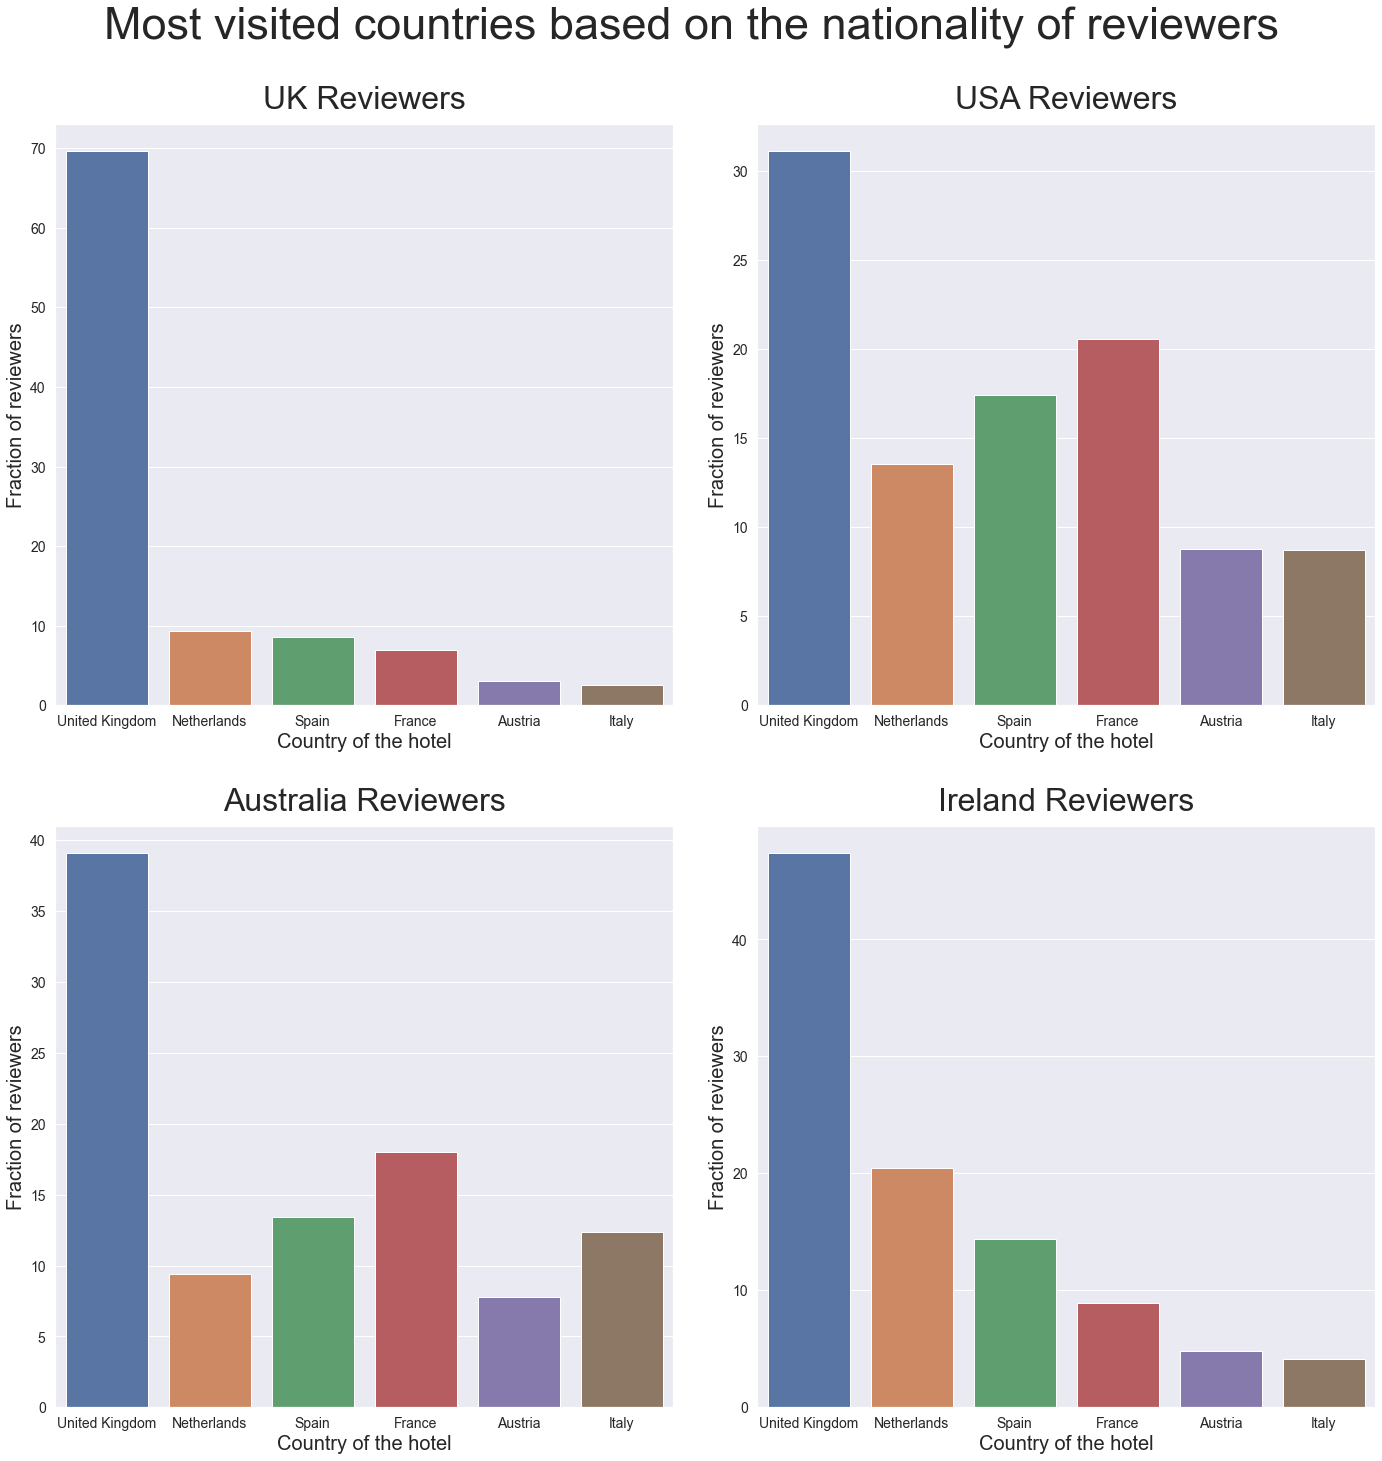

In [18]:
uk_reviewers = df[df["Reviewer_Nationality"] == " United Kingdom "]
us_reviewers = df[df["Reviewer_Nationality"] == " United States of America "]
aus_reviewers = df[df["Reviewer_Nationality"] == " Australia "]
ir_reviewers = df[df["Reviewer_Nationality"] == " Ireland "]

fig, axs = plt.subplots(2, 2, figsize=(20, 20))
fig.suptitle("Most visited countries based on the nationality of reviewers", fontsize=45, y=1.03)

sb.barplot(x=uk_reviewers.Hotel_Country.value_counts().index, y=uk_reviewers.Hotel_Country.value_counts(normalize=True)*100, 
           ax=axs[0, 0], order=uk_reviewers.Hotel_Country.value_counts().index)
axs[0, 0].set_title("UK Reviewers", size=32, pad=15)

sb.barplot(x=us_reviewers.Hotel_Country.value_counts().index, y=us_reviewers.Hotel_Country.value_counts(normalize=True)*100, 
           ax=axs[0, 1], order=uk_reviewers.Hotel_Country.value_counts().index)
axs[0, 1].set_title("USA Reviewers", size=32, pad=15)

sb.barplot(x=aus_reviewers.Hotel_Country.value_counts().index, y=aus_reviewers.Hotel_Country.value_counts(normalize=True)*100, 
           ax=axs[1, 0], order=uk_reviewers.Hotel_Country.value_counts().index)
axs[1, 0].set_title("Australia Reviewers", size=32, pad=15)

sb.barplot(x=ir_reviewers.Hotel_Country.value_counts().index, y=ir_reviewers.Hotel_Country.value_counts(normalize=True)*100, 
           ax=axs[1, 1], order=uk_reviewers.Hotel_Country.value_counts().index)
axs[1, 1].set_title("Ireland Reviewers", size=32, pad=15)

for ax in axs.flat:
    #ax.set(xlabel="Country of the hotel", ylabel="Fraction of reviewers")
    ax.set_xlabel("Country of the hotel", fontsize=20)
    ax.set_ylabel("Fraction of reviewers", fontsize=20)
    ax.tick_params(labelsize=14)
    
    #ax.label_outer()
 

fig.tight_layout(pad=3)

In [19]:
#Very interesting comparison between average score and average reviewer score for each hotel
#This also indicates that the dataset does not contain all reviews which have been counted towards average score

first10_most_common_rev_nats = keep_most_frequent(df, 10, "Reviewer_Nationality")
first10_most_common_rev_nats.groupby("Reviewer_Nationality").Average_Score.agg(["mean", "count"])

,mean,count
Reviewer_Nationality,,
Australia,8.461759,21686
Canada,8.446922,7894
Germany,8.364853,7941
Ireland,8.330573,14827
Netherlands,8.398928,8772
Saudi Arabia,8.403005,8951
Switzerland,8.468299,8678
United Arab Emirates,8.443332,10235
United Kingdom,8.377914,245246


In [20]:
first10_most_common_rev_nats.groupby("Reviewer_Nationality").Reviewer_Score.agg(["mean", "count"])

,mean,count
Reviewer_Nationality,,
Australia,8.591718,21686
Canada,8.547783,7894
Germany,8.132477,7941
Ireland,8.464052,14827
Netherlands,8.125148,8772
Saudi Arabia,7.881767,8951
Switzerland,8.161593,8678
United Arab Emirates,7.878828,10235
United Kingdom,8.486352,245246


In [21]:
first10_most_common_rev_nats.groupby("Reviewer_Nationality").Review_Total_Positive_Word_Counts.agg(["mean", "count"])

,mean,count
Reviewer_Nationality,,
Australia,20.698100,21686
Canada,21.471751,7894
Germany,20.030097,7941
Ireland,18.661024,14827
Netherlands,17.954514,8772
Saudi Arabia,11.261423,8951
Switzerland,17.664669,8678
United Arab Emirates,14.673766,10235
United Kingdom,17.590929,245246


In [22]:
first10_most_common_rev_nats.groupby("Reviewer_Nationality").Review_Total_Negative_Word_Counts.agg(["mean", "count"])

,mean,count
Reviewer_Nationality,,
Australia,17.195610,21686
Canada,18.934001,7894
Germany,22.108173,7941
Ireland,19.361570,14827
Netherlands,20.174533,8772
Saudi Arabia,15.072841,8951
Switzerland,21.252017,8678
United Arab Emirates,18.238202,10235
United Kingdom,18.894481,245246


In [23]:
#To see whether the reviewers tend to be biased towards hotels from their home country or not

sub_df = df[df["Reviewer_Nationality"].isin([" Austria ", " United Kingdom ", " Spain ", " Netherlands ", " Italy ", " France "])]
sub_df.groupby(["Hotel_Country", "Reviewer_Nationality"]).Reviewer_Score.agg(["mean", "median", "count"])

mean  median   count
Hotel_Country  Reviewer_Nationality                          
Austria         Austria              8.368240    8.80     932
                France               8.381660    8.80     518
                Italy                8.266114    8.80     664
                Netherlands          8.333787    8.80     808
                Spain                8.228213    8.80     319
                United Kingdom       8.807073    9.20    7507
France          Austria              8.660697    9.20     201
                France               8.247043    8.80    1860
                Italy                8.100000    8.80     713
                Netherlands          8.221886    8.80    1485
                Spain                8.115265    8.80     452
                United Kingdom       8.564608    9.20   16908
Italy           Austria              8.172772    8.55     202
                France               8.031630    8.30     724
                Italy                8.146106    8.30    1451
                Netherlands          8.003218    8.30     777
                Spain                7.955592    8.30     304
                United Kingdom       8.453392    8.80    6205
Netherlands     Austria              8.232850    8.80     207
                France               8.137664    8.80     762
                Italy                8.209663    8.80     652
                Netherlands          8.130929    8.30    1733
                Spain                8.240547    8.80     439
                United Kingdom       8.583742    9.20   23016
Spain           Austria              8.274061    8.80     293
                France               8.167685    8.80    1080
                Italy                8.263795    8.80     743
                Netherlands          8.274269    8.80    1232
                Spain                8.315748    8.80    1778
                United Kingdom       8.716574    9.20   20961
United Kingdom  Austria              8.199133    8.80     577
                France               8.039073    8.30    2352
                Italy                7.951190    8.30    1891
                Netherlands          7.974900    8.30    2737
                Spain                8.014325    8.30    1445
                United Kingdom       8.424274    8.80  170649

<h2>Individual hotels analysis</h2>

In [24]:
most_common_hotels = keep_more_frequent(df, 10, "Hotel_Name")
sorted_hotels = most_common_hotels.groupby("Hotel_Name").Average_Score.agg(["mean", "count"]).sort_values(by="mean", ascending=False)
sorted_hotels

,mean,count
Hotel_Name,,
Ritz Paris,9.8,28
41,9.6,103
H tel de La Tamise Esprit de France,9.6,61
H10 Casa Mimosa 4 Sup,9.6,116
Haymarket Hotel,9.6,121
...,...,...
The Tophams Hotel,6.6,180
Best Western Maitrise Hotel Edgware Road,6.6,220
Savoy Hotel Amsterdam,6.4,243


In [25]:
most_common_hotels.groupby("Hotel_Name").Reviewer_Score.agg(["mean", "count"]).sort_values(by="mean", ascending=False)

,mean,count
Hotel_Name,,
Ritz Paris,9.725000,28
Hotel Casa Camper,9.718937,301
41,9.711650,103
H tel de La Tamise Esprit de France,9.688525,61
Le Narcisse Blanc Spa,9.671930,57
...,...,...
Holiday Inn Paris Montparnasse Pasteur,6.329730,37
Savoy Hotel Amsterdam,6.009465,243
Villa Eugenie,5.864516,62


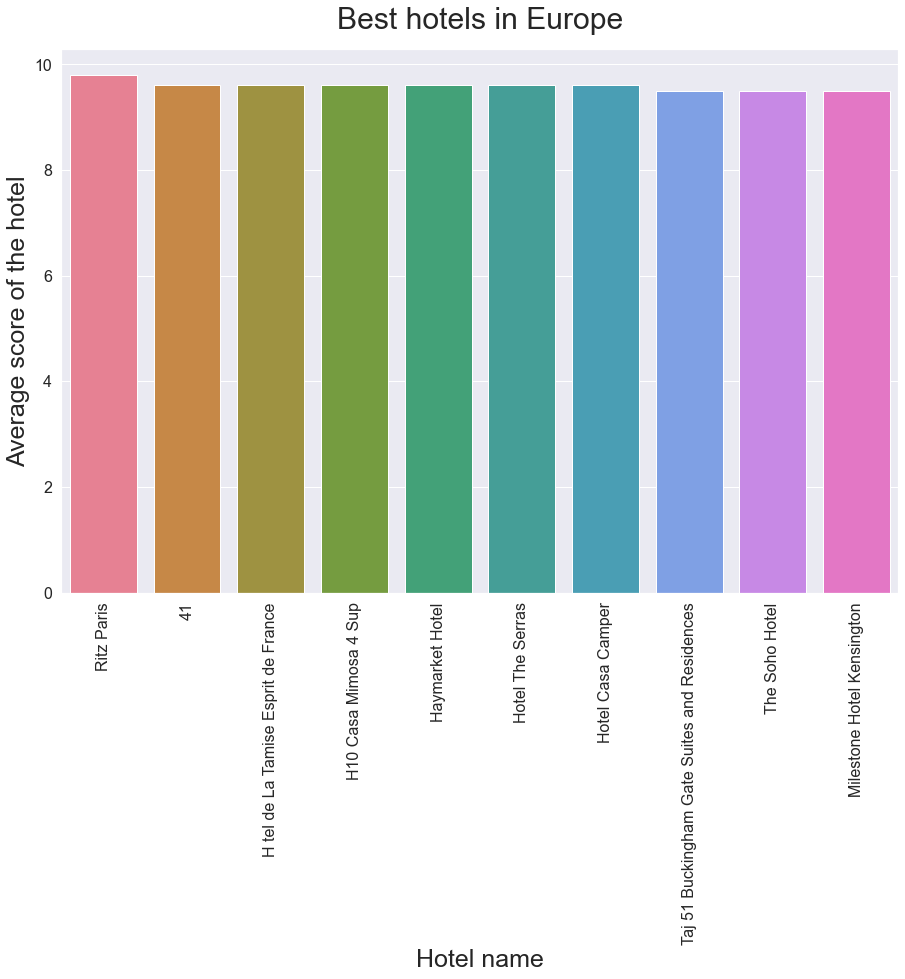

In [26]:
top10 = pd.DataFrame(sorted_hotels.iloc[:10, :]).reset_index()

plt.figure(figsize=(15, 10))
sb.barplot(x="Hotel_Name", y="mean", data=top10, palette="husl")

plt.title("Best hotels in Europe", fontsize=30, pad=20)
plt.xlabel("Hotel name", fontsize=25)
plt.ylabel("Average score of the hotel", fontsize=25)
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16)

plt.show()

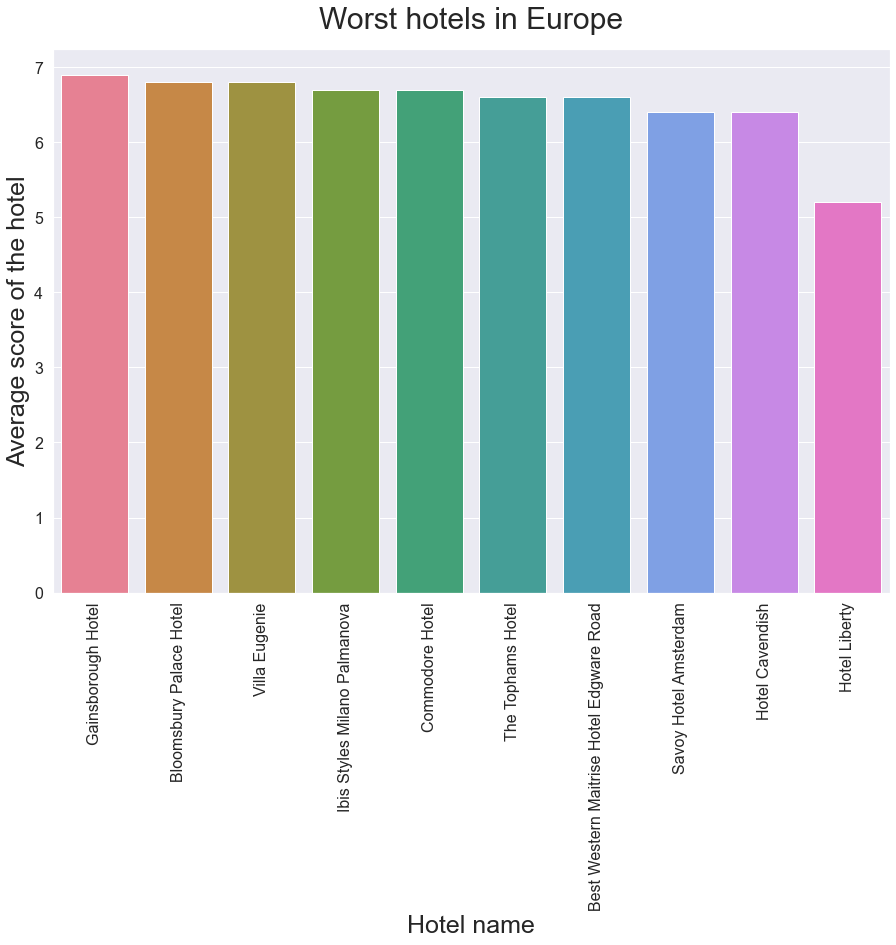

In [27]:
worst10 = pd.DataFrame(sorted_hotels.iloc[-10:, :]).reset_index()

plt.figure(figsize=(15, 10))
sb.barplot(x="Hotel_Name", y="mean", data=worst10, palette="husl")

plt.title("Worst hotels in Europe", fontsize=30, pad=20)
plt.xlabel("Hotel name", fontsize=25)
plt.ylabel("Average score of the hotel", fontsize=25)
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16)

plt.show()

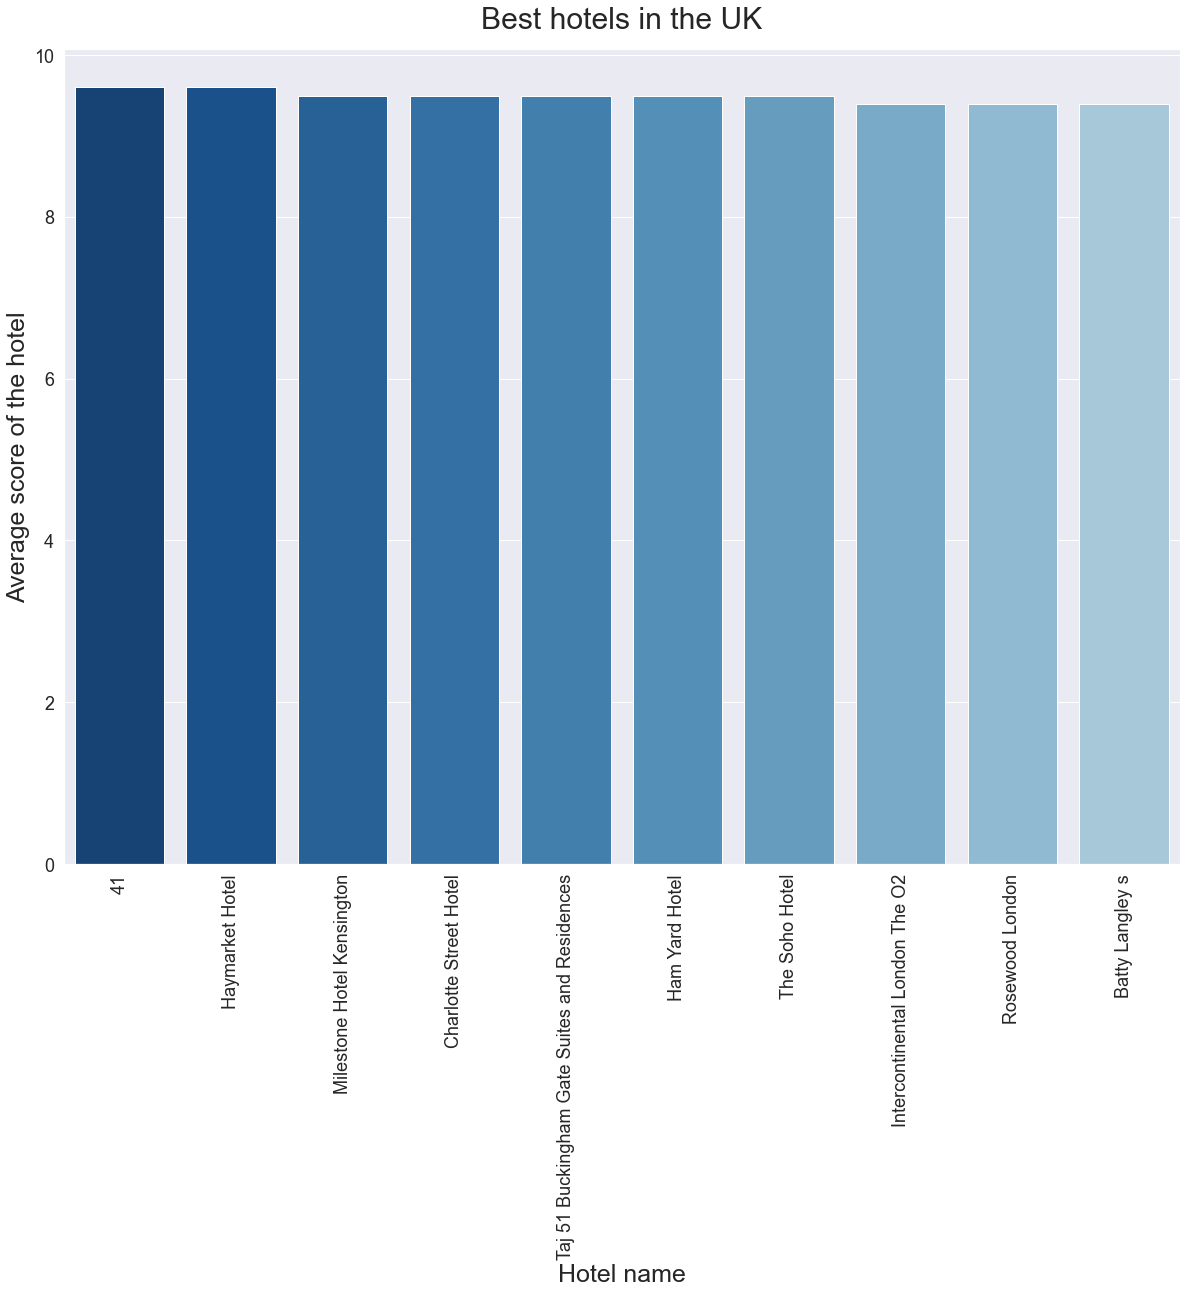

In [28]:
#Any country can be chosen for this chart

UK = most_common_hotels[most_common_hotels["Hotel_Country"] == "United Kingdom"]
top10_UK = UK.groupby("Hotel_Name").Average_Score.agg(["mean", "count"]).sort_values(by="mean", ascending=False).iloc[:10, :].reset_index()

plt.figure(figsize=(20, 15))
sb.barplot(x="Hotel_Name", y="mean", data=top10_UK, palette=sb.color_palette("Blues_r", 15))

plt.title("Best hotels in the UK", fontsize=30, pad=20)
plt.xlabel("Hotel name", fontsize=25)
plt.ylabel("Average score of the hotel", fontsize=25)
plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18)

plt.show()

<h2>Comparing the extremes (best/worst hotels) of each country</h2>

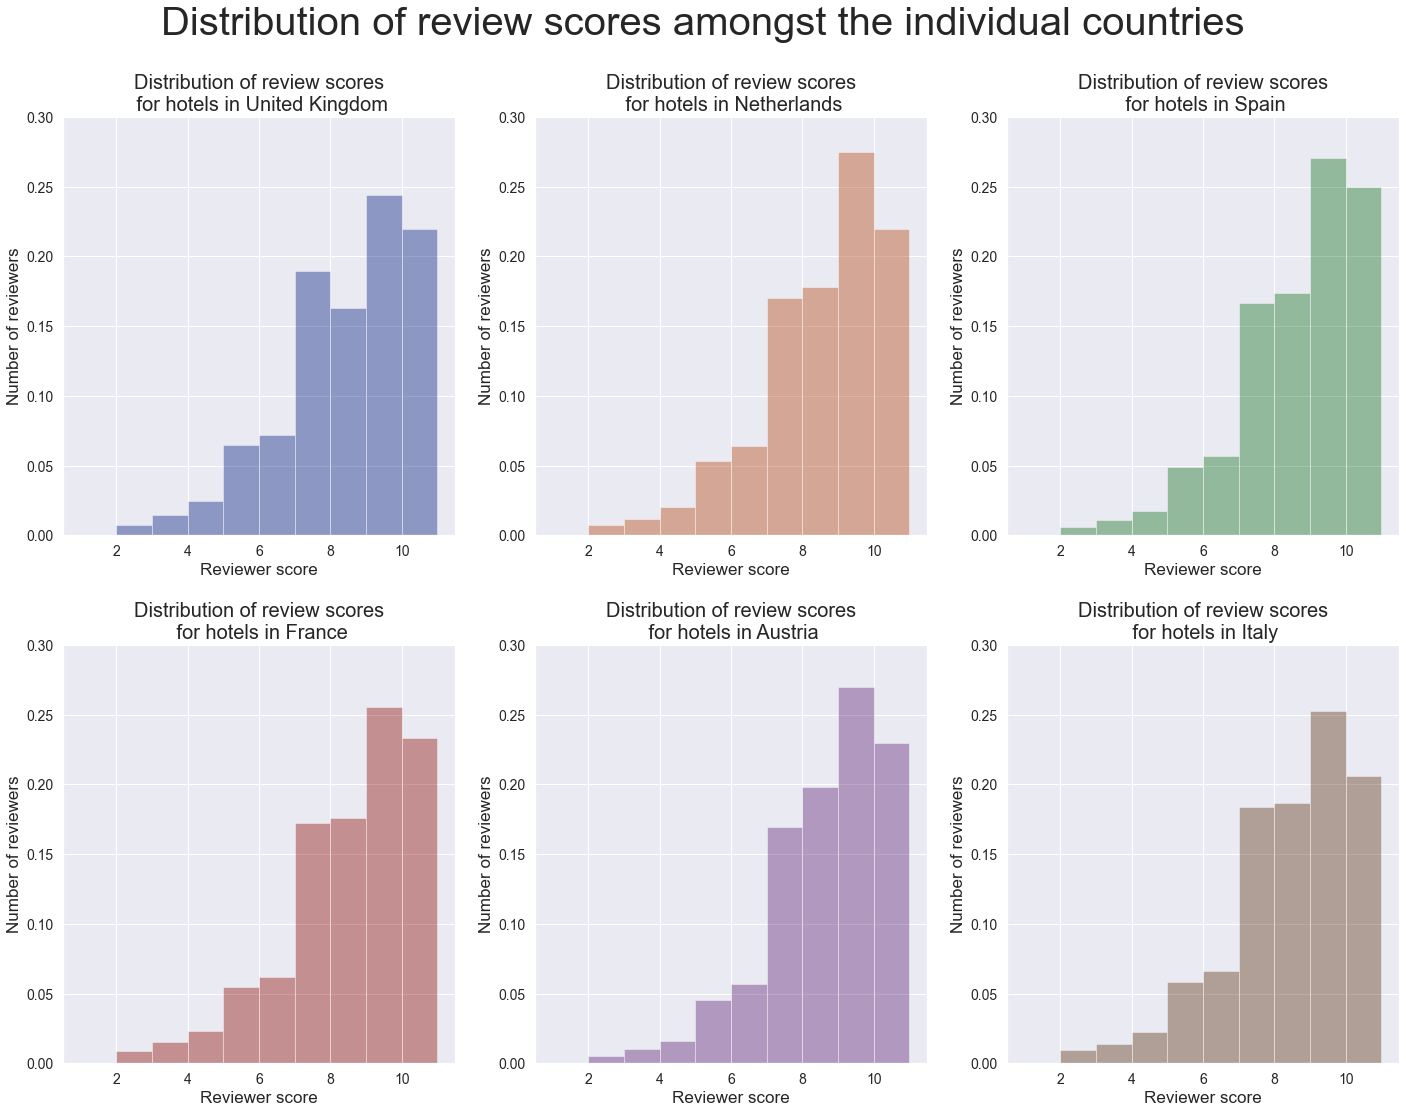

In [29]:
fig, axs = plt.subplots(2, 3, figsize=(20, 15))

i, j, k = 0, 0, 0
cp = sb.color_palette(palette="dark")
countries = ["United Kingdom", "Netherlands", "Spain", "France", "Austria", "Italy"]

for country in countries:
    sub = df[df["Hotel_Country"] == country]
    sb.distplot(sub["Reviewer_Score"], bins=range(1, 12), norm_hist=True, kde=False, ax=axs[i, j], color=cp[k])
    
    axs[i, j].set_title(f"Distribution of review scores\n for hotels in {country}", size=20)
    axs[i, j].set_xlabel("Reviewer score", fontsize=17)
    axs[i, j].set_ylabel("Number of reviewers", fontsize=17)
    axs[i, j].set_yticks([x/100 for x in range(0, 31, 5)])
    axs[i, j].tick_params(labelsize=14)
    
    j += 1
    if j == 3:
        j = 0
        i += 1
    k += 1

fig.suptitle("Distribution of review scores amongst the individual countries", fontsize=40, y=1.04)

fig.tight_layout(pad=2)

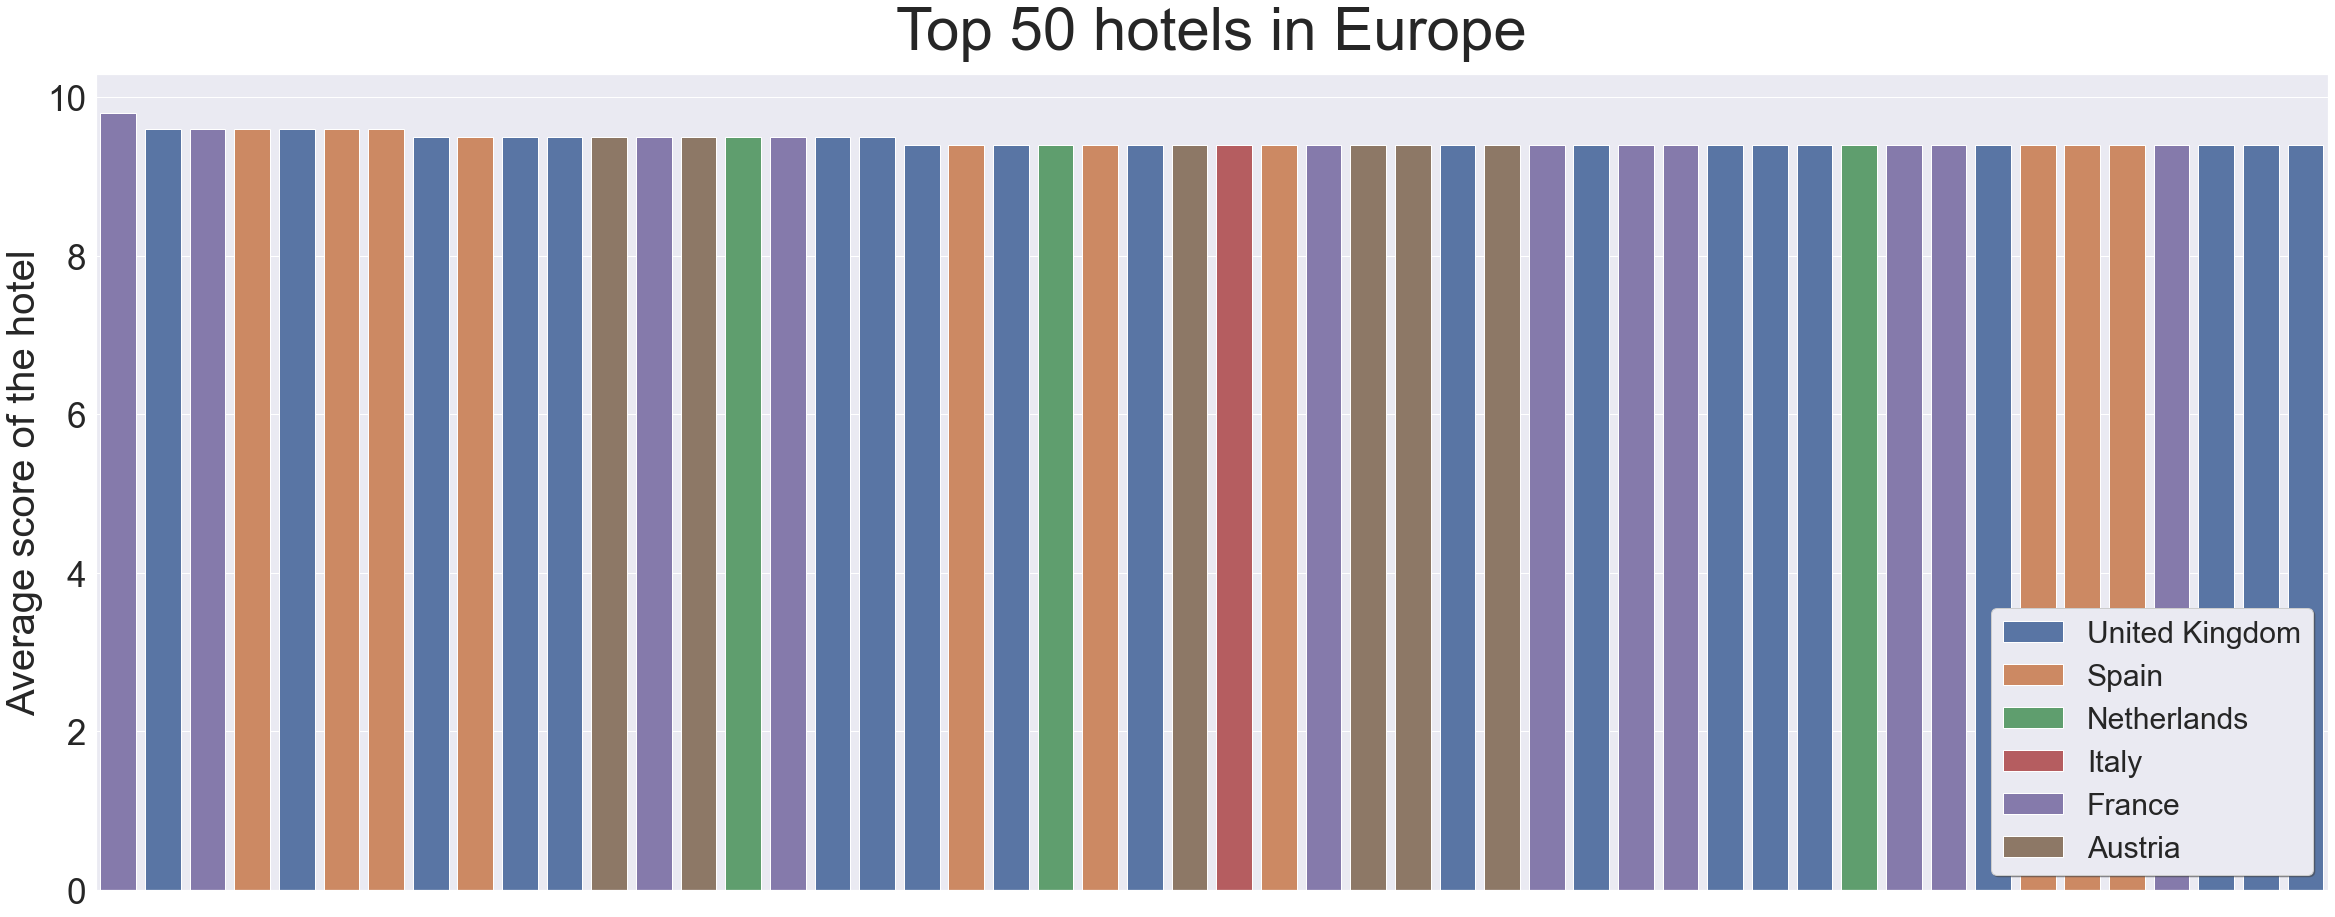

In [30]:
top50 = most_common_hotels.groupby(["Hotel_Name", "Hotel_Country"]).Average_Score.agg(["mean"]).sort_values(by="mean", ascending=False).reset_index().iloc[:50, :]

plt.figure(figsize=(40, 15))
sb.barplot(x="Hotel_Name", y="mean", hue="Hotel_Country", data=top50, dodge=False,
           hue_order=["United Kingdom", "Spain", "Netherlands", "Italy", "France", "Austria"])

plt.title("Top 50 hotels in Europe", fontsize=60, pad=25)
plt.xlabel("")
plt.ylabel("Average score of the hotel", fontsize=40)
plt.xticks([])
plt.yticks(fontsize=35)
plt.legend(fontsize=30, loc=4, shadow=True, framealpha=1)

plt.show()

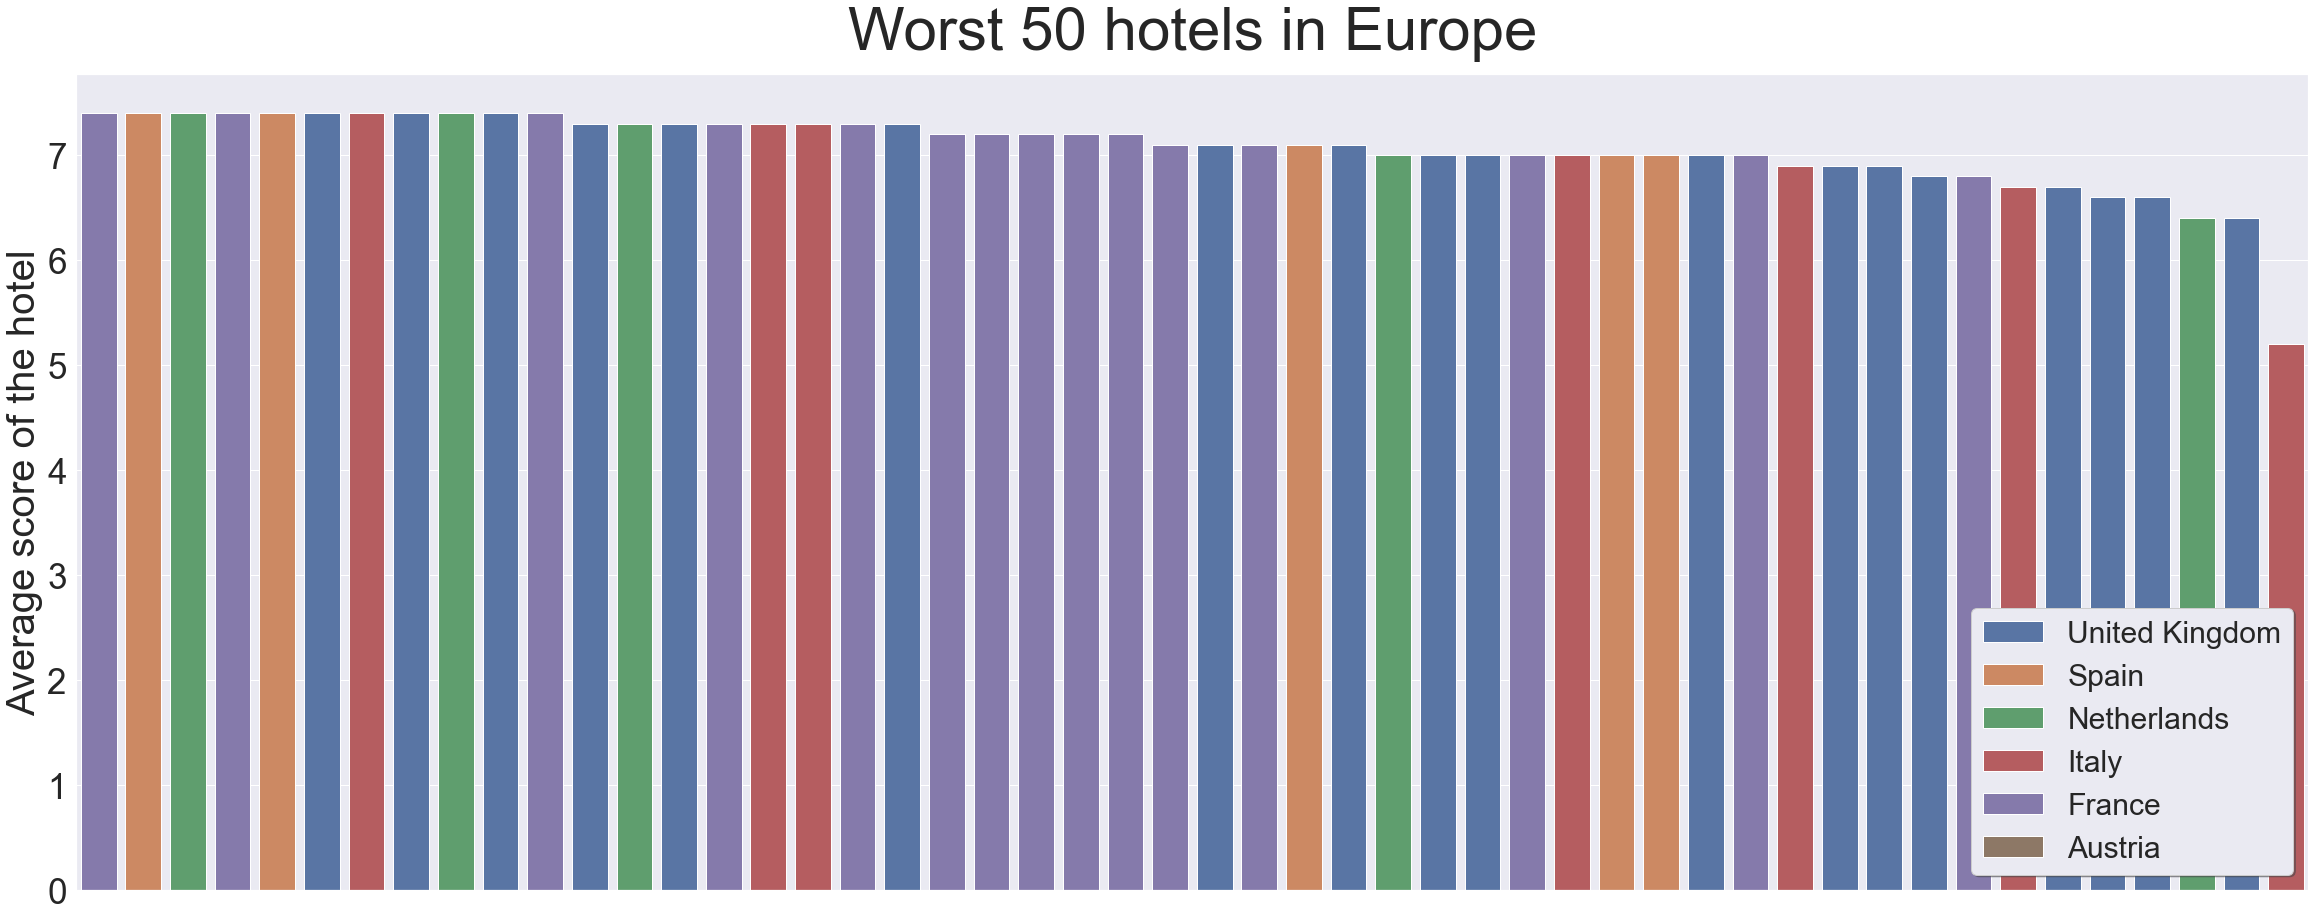

In [31]:
worst50 = most_common_hotels.groupby(["Hotel_Name", "Hotel_Country"]).Average_Score.agg(["mean"]).sort_values(by="mean", ascending=False).reset_index().iloc[-50:, :]

plt.figure(figsize=(40, 15))
sb.barplot(x="Hotel_Name", y="mean", hue="Hotel_Country", data=worst50, dodge=False,
           hue_order=["United Kingdom", "Spain", "Netherlands", "Italy", "France", "Austria"])

plt.title("Worst 50 hotels in Europe", fontsize=60, pad=25)
plt.xlabel("")
plt.ylabel("Average score of the hotel", fontsize=40)
plt.xticks([])
plt.yticks(fontsize=35)
plt.legend(fontsize=30, loc=4, shadow=True, framealpha=1)

plt.show()

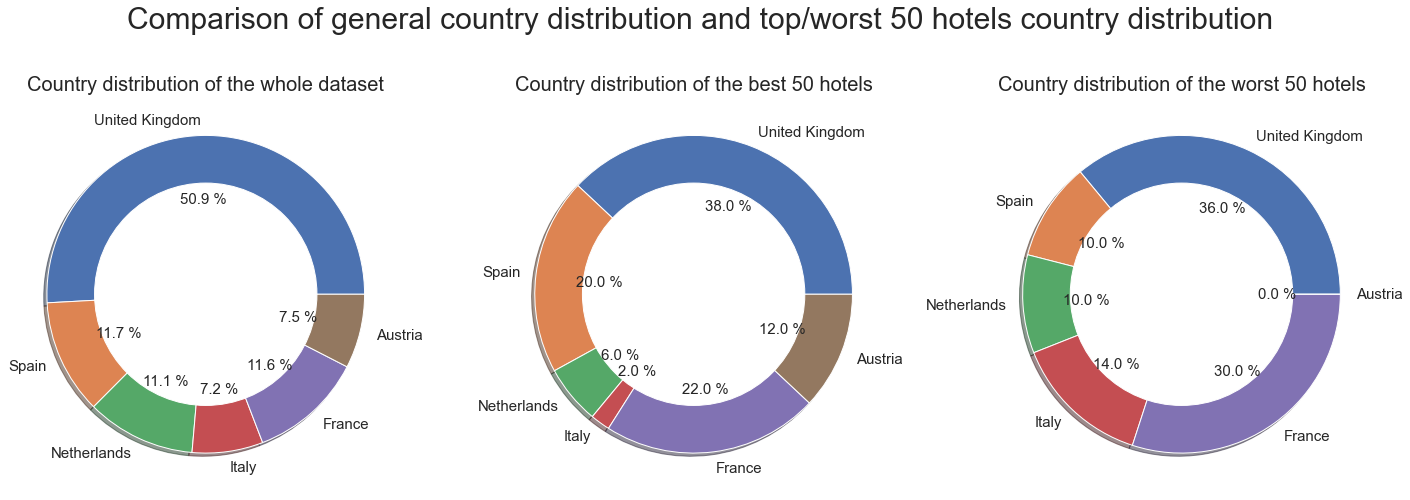

In [32]:
worst50 = most_common_hotels.groupby(["Hotel_Name", "Hotel_Country"]).Average_Score.agg(["mean"]).sort_values(by="mean", ascending=True).reset_index().iloc[:50, :]
best50 = most_common_hotels.groupby(["Hotel_Name", "Hotel_Country"]).Average_Score.agg(["mean"]).sort_values(by="mean", ascending=False).reset_index().iloc[:50, :]

countries = ["United Kingdom", "Spain", "Netherlands", "Italy", "France", "Austria"]

sizes_w = (worst50["Hotel_Country"].value_counts(normalize=True)*100).sort_index(ascending=False)
sizes_b = (best50["Hotel_Country"].value_counts(normalize=True)*100).sort_index(ascending=False)
sizes = (most_common_hotels["Hotel_Country"].value_counts(normalize=True)*100).sort_index(ascending=False)

for size in [sizes_w, sizes_b, sizes]:
    for country in countries:
        if country not in size:
            size[country] = 0

fig, axs = plt.subplots(1, 3, figsize=(20, 20))

axs[0].pie(sizes, labels=countries, shadow=True, textprops={"size":15}, autopct="%.1f %%")
axs[0].add_artist(plt.Circle((0, 0), 0.7, color="white"))
axs[0].set_title("Country distribution of the whole dataset", size=20)

axs[1].pie(sizes_b, labels=countries, shadow=True, textprops={"size":15}, autopct="%.1f %%")
axs[1].add_artist(plt.Circle((0, 0), 0.7, color="white"))
axs[1].set_title("Country distribution of the best 50 hotels", size=20)

axs[2].pie(sizes_w, labels=countries, shadow=True, textprops={"size":15}, autopct="%.1f %%")
axs[2].add_artist(plt.Circle((0, 0), 0.7, color="white"))
axs[2].set_title("Country distribution of the worst 50 hotels", size=20)

plt.suptitle("Comparison of general country distribution and top/worst 50 hotels country distribution", fontsize=30, y=0.7)

fig.tight_layout()

#From these plots we can see some relations which were hidden from us in the average rating for each country
#This comparison helps us avoid some incorrect conclusion which could be made from the previous bar plots
#As we can see, in terms of best/worst hotels, UK actually performs quite poorly, as well as Netherlands
#We can also tell that French hotels perform really bad in terms of the extremes as France takes up huge part of the worst 50
#Austria and Spain are the two countries that really shine in this comparison as their parts in both top and worst 50
#are very complimenting

<h2>Time analysis</h2>

In this part, the perspective of time is taken. The evolution of the average reviewer score is examined and these evolutions are then compared within several hotels.

In [33]:
df["Review_Date"].max() - df["Review_Date"].min()

Timedelta('730 days 00:00:00')

In [34]:
def fill_outliers(dataf):
    temp = dataf.copy().reset_index()
    med_count = np.median(temp["count"])
    for ind, row in temp.iterrows():
        if temp.iloc[ind]["count"] < med_count:
            
            if not ind:
                if temp.iloc[ind+1]["count"] > med_count:
                    temp.at[ind, "mean"] = (temp.iloc[ind]["mean"] + temp.iloc[ind+1]["mean"])/2
                else:
                    temp.at[ind, "mean"] = np.NaN
            
            elif ind == len(temp)-1:
                if temp.iloc[ind-1]["count"] > med_count:
                    temp.at[ind, "mean"] = (temp.iloc[ind-1]["mean"] + temp.iloc[ind]["mean"])/2
                else:
                    temp.at[ind, "mean"] = np.NaN
            
            else:
                if temp.iloc[ind-1]["count"] > med_count and temp.iloc[ind+1]["count"] > med_count:
                    temp.at[ind, "mean"] = (temp.iloc[ind-1]["mean"] + temp.iloc[ind]["mean"] + temp.iloc[ind+1]["mean"])/3
                else:
                    temp.at[ind, "mean"] = np.NaN
    temp["mean"] = round((temp["mean"].ffill()+temp["mean"].bfill())/2, 3)
    return temp

In [35]:
def time_evo_review_hotel(dataf, hotel_name, fs): #"W" for weekly, "M" for monthly, "A" for yearly
    only_hotel = dataf[dataf["Hotel_Name"] == hotel_name].reset_index()  
    hotel_resampled = only_hotel.resample(fs, on="Review_Date")["Reviewer_Score"].agg(["mean", "count"])
    return fill_outliers(hotel_resampled).rename(columns={"mean": "Reviewer_Score"})

In [36]:
def hotel_evolution_monthly(dataf, hotel_name):
    hotel_monthly = time_evo_review_hotel(dataf, hotel_name, "M")
    
    plt.figure(figsize=(20, 10))
    sb.lineplot(x=hotel_monthly["Review_Date"], y=hotel_monthly["Reviewer_Score"], sort=False)
    
    plt.title(f"Evolution of average reviews over the course of 730 days for hotel {hotel_name}", fontsize=30)
    plt.xlabel("Time", fontsize=20)
    plt.ylabel("Average score during each month", fontsize=20)
    plt.xticks(hotel_monthly["Review_Date"], fontsize=16, rotation=60)
    plt.yticks(fontsize=16)

    plt.show()

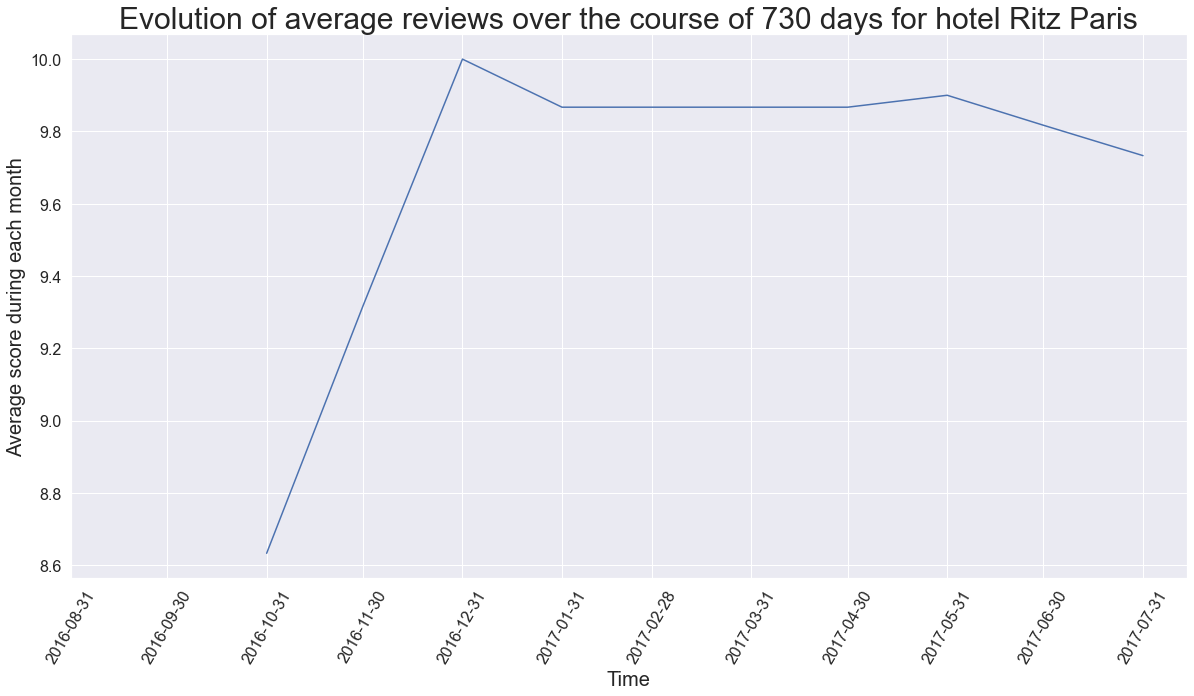

In [37]:
hotel_evolution_monthly(df, "Ritz Paris")

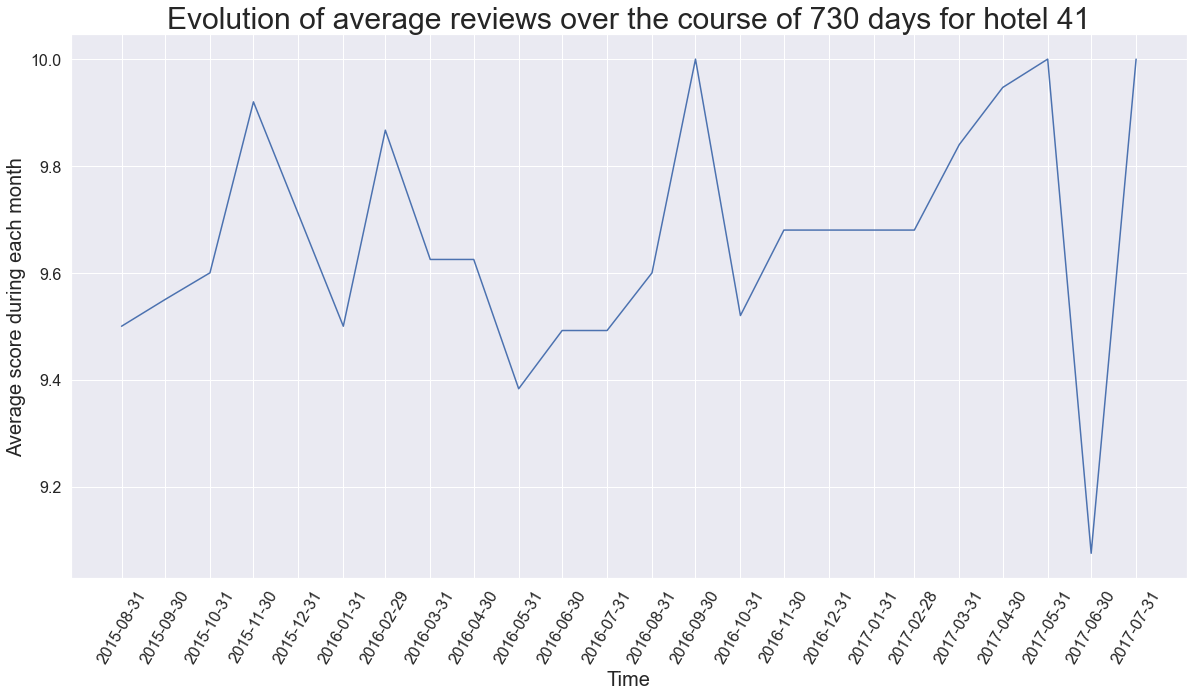

In [38]:
hotel_evolution_monthly(df, "41")

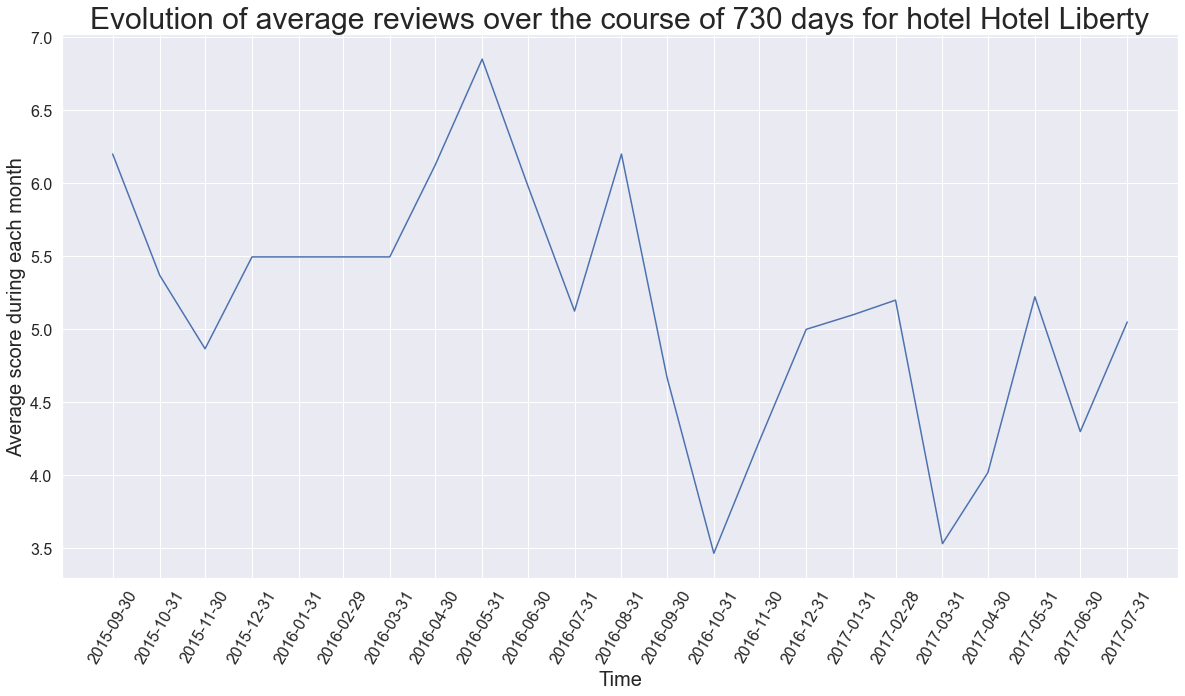

In [39]:
hotel_evolution_monthly(df, "Hotel Liberty")

In [40]:
def compare_n_hotels(dataf, hotels):
    first = dataf["Review_Date"].min()
    last = dataf["Review_Date"].max()
    hotel_names = hotels
    hotels = [time_evo_review_hotel(dataf, hotel, "M").drop(columns=["count"]) for hotel in hotels]
    for ind, hotel in enumerate(hotels):
        hotel.set_index("Review_Date", inplace=True)
        hotel.rename(columns={"Reviewer_Score": f"{hotel_names[ind]}"}, inplace=True)
    melted = (pd.concat(hotels, join="outer", axis=1)).reset_index().melt("Review_Date", var_name="Hotel", value_name="Reviewer_Score")
    
    plt.figure(figsize=(20, 10))
    sb.lineplot(x="Review_Date", y="Reviewer_Score", hue="Hotel", data=melted, sort=False)
    
    plt.title(f"Comparison of evolution of reviews over time for chosen hotels", fontsize=30)
    plt.xlabel("Time", fontsize=20)
    plt.ylabel("Average score during each month", fontsize=20)
    plt.xticks(pd.date_range(start=first, end=last, freq="M"), fontsize=16, rotation=60)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=20, shadow=True, framealpha=1)

    plt.show()

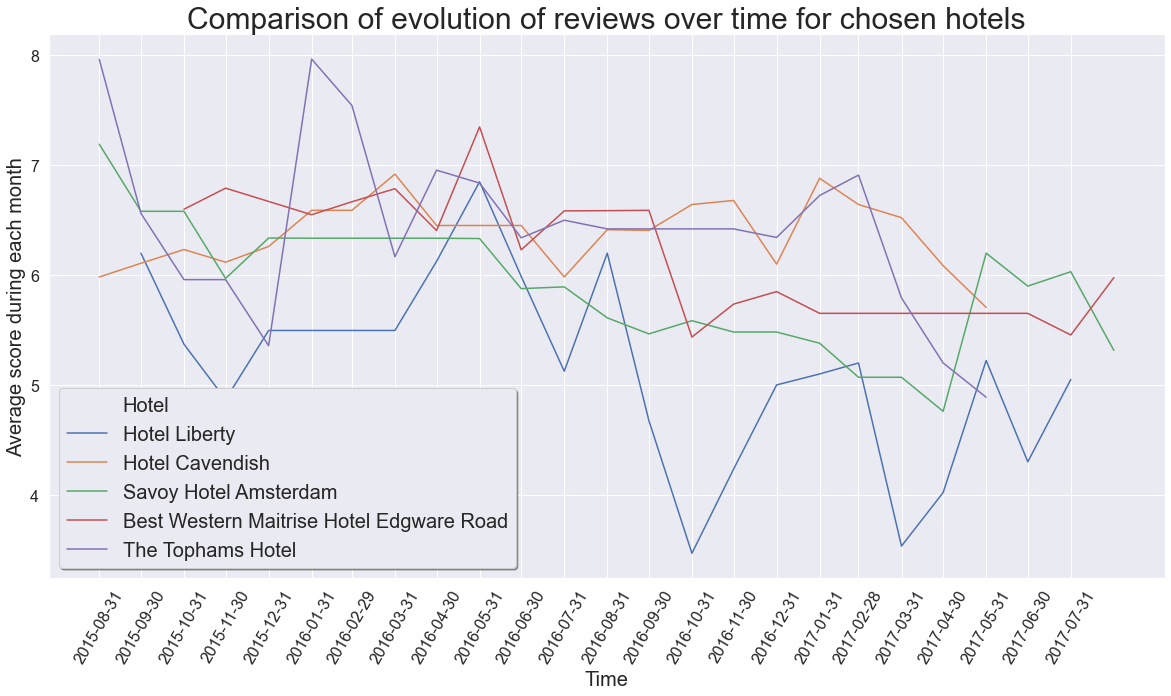

In [41]:
#Any number of any hotels can be chosen, however the graph gets quite messy for more than a few

compare_n_hotels(df, worst50["Hotel_Name"].unique()[:5])

<h2>Diving into tags of each review</h2>

In this section, I have dived into tags of each review. Those were organised chunks of text, from which I have extracted pieces of information about each reviewers length of stay, presence of pet, purpose of their trip or their travel group.

In [8]:
df["Tags"] = df_orig["Tags"]

In [9]:
df["Tags"] = df["Tags"].apply(lambda x: x.strip().replace(" '", "").replace("' ", "").replace("[", "").replace("]", "").split(", "))

In [10]:
def process_tag(val):
    
    if "pet" not in val[0].split():
        val = [0] + val
    else:
        val[0] = 1
    
    if "trip" not in val[1].split():
        val.insert(1, np.NaN)
    
    if "device" in val[-1].split():
        del val[-1]
    
    if len(val) == 5:
        del val[3]
        val[3] = "".join(re.findall(r"[1-9]", val[3]))
    elif len(val) == 4:
        if "Stayed" in val[-1].split():
            val[3] = "".join(re.findall(r"[1-9]", val[3]))
        else:
            val[3] = np.NaN
    else:
        val.append(np.NaN)
    
    return val
    

In [11]:
df["Tags"] = df["Tags"].apply(process_tag)

In [12]:
df["Pet"] = df["Tags"].apply(lambda x: x[0])
df["Travel_Purpose"] = df["Tags"].apply(lambda x: x[1])
df["Traveled_as"] = df["Tags"].apply(lambda x: x[2])
df["Stay_Length"] = df["Tags"].apply(lambda x: float(x[3]))

In [13]:
#Missing travel purpose values have been filled according to the distribution of the non-missing entries
#Missing length of stay values have been filled with the median of known stay lengths

vc = df["Travel_Purpose"].value_counts(normalize=True)

df["Travel_Purpose"].fillna(pd.Series(np.random.choice(["Leisure trip", "Business trip"], p=[vc[0], 1-vc[0]], size=len(df["Travel_Purpose"]))),
                           inplace=True)
df["Stay_Length"].fillna(df["Stay_Length"].median(), inplace=True)
df["Stay_Length"] = df["Stay_Length"].astype("int")

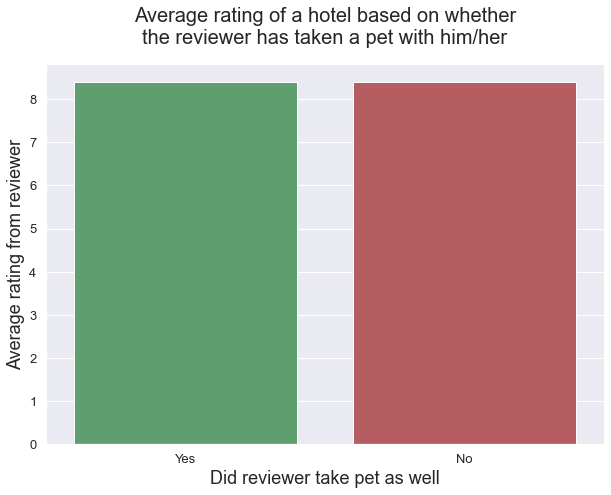

In [48]:
pets = df.groupby("Pet").Reviewer_Score.agg(["mean"]).reset_index().replace({0: "No", 1: "Yes"})

plt.figure(figsize=(10, 7))
sb.barplot(x=pets["Pet"], y=pets["mean"], order=["Yes", "No"], palette=["g", "r"])

plt.title("Average rating of a hotel based on whether\nthe reviewer has taken a pet with him/her", fontsize=20, pad=20)
plt.xlabel("Did reviewer take pet as well", fontsize=18)
plt.ylabel("Average rating from reviewer", fontsize=18)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13)

plt.show()

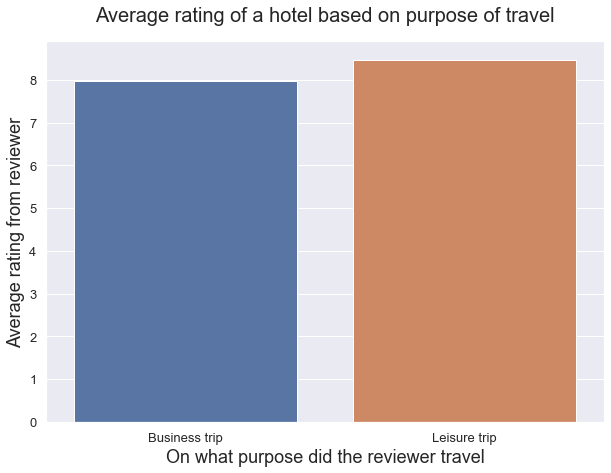

In [49]:
purpose = df.groupby("Travel_Purpose").Reviewer_Score.agg(["mean"]).reset_index()

plt.figure(figsize=(10, 7))
sb.barplot(x=purpose["Travel_Purpose"], y=purpose["mean"])

plt.title("Average rating of a hotel based on purpose of travel", fontsize=20, pad=20)
plt.xlabel("On what purpose did the reviewer travel", fontsize=18)
plt.ylabel("Average rating from reviewer", fontsize=18)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13)

plt.show()

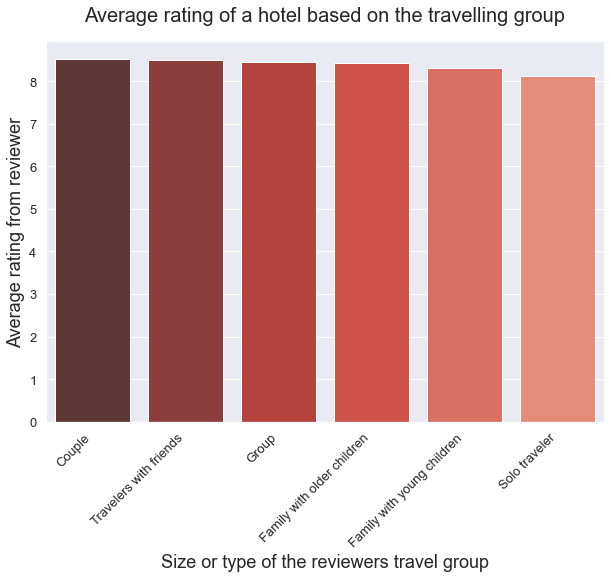

In [50]:
group = df.groupby("Traveled_as").Reviewer_Score.agg(["mean"]).reset_index().sort_values(by="mean", ascending=False)

plt.figure(figsize=(10, 7))
sb.barplot(x=group["Traveled_as"], y=group["mean"], palette="Reds_d")

plt.title("Average rating of a hotel based on the travelling group", fontsize=20, pad=20)
plt.xlabel("Size or type of the reviewers travel group", fontsize=18)
plt.ylabel("Average rating from reviewer", fontsize=18)
plt.xticks(fontsize=13, rotation=45, ha="right")
plt.yticks(fontsize=13)

plt.show()

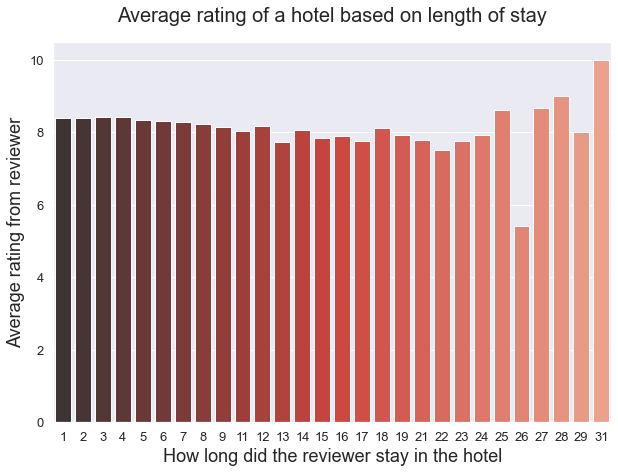

In [51]:
#The extreme values (25 days & more) are verry rare and could be removed

stay_length = df.groupby("Stay_Length").Reviewer_Score.agg(["mean"]).reset_index()

plt.figure(figsize=(10, 7))
sb.barplot(x=stay_length["Stay_Length"], y=stay_length["mean"], palette="Reds_d")

plt.title("Average rating of a hotel based on length of stay", fontsize=20, pad=20)
plt.xlabel("How long did the reviewer stay in the hotel", fontsize=18)
plt.ylabel("Average rating from reviewer", fontsize=18)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13)

plt.show()

In [52]:
sub_df = df.copy()
sub_df["Stay_Length"] = pd.cut(sub_df["Stay_Length"], (0, 5, 10, 15, 35), labels=["1-5 days", 
                                                                                  "5-10 days", 
                                                                                  "10-15 days", 
                                                                                  "More than 15 days"])

In [53]:
sub_df.groupby(["Traveled_as", "Stay_Length"]).Reviewer_Score.agg(["mean", "count"])

mean   count
Traveled_as                Stay_Length                        
Couple                     1-5 days           8.515123  243340
                           5-10 days          8.447684    8529
                           10-15 days         8.209814     377
                           More than 15 days  8.072917      48
Family with older children 1-5 days           8.449835   24571
                           5-10 days          8.264516    1612
                           10-15 days         7.905224     134
                           More than 15 days  7.581250      32
Family with young children 1-5 days           8.318843   56715
                           5-10 days          8.131135    3912
                           10-15 days         7.752096     334
                           More than 15 days  7.812963      54
Group                      1-5 days           8.460884   63059
                           5-10 days          8.176071    2194
                           10-15 days         8.054167     120
                           More than 15 days  8.378947      19
Solo traveler              1-5 days           8.126154  103429
                           5-10 days          8.209085    4645
                           10-15 days         8.025464     377
                           More than 15 days  7.871277      94
Travelers with friends     1-5 days           8.519884    2062
                           5-10 days          7.915385      78
                           10-15 days         9.200000       2
                           More than 15 days  9.200000       1

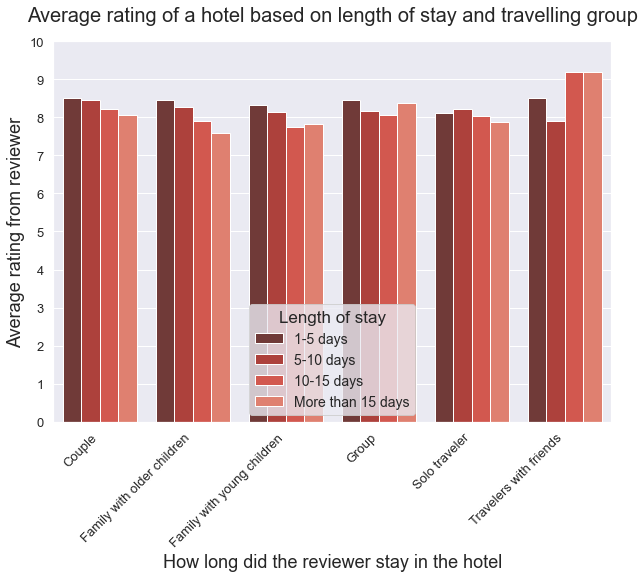

In [54]:
stay_length_and_group = sub_df.groupby(["Traveled_as", "Stay_Length"]).Reviewer_Score.agg(["mean"]).reset_index()

plt.figure(figsize=(10, 7))
sb.barplot(x="Traveled_as", y="mean", data=stay_length_and_group, hue="Stay_Length", palette="Reds_d")

plt.title("Average rating of a hotel based on length of stay and travelling group", fontsize=20, pad=20)
plt.xlabel("How long did the reviewer stay in the hotel", fontsize=18)
plt.ylabel("Average rating from reviewer", fontsize=18)
plt.xticks(fontsize=13, rotation=45, ha="right")
plt.yticks(range(11), fontsize=13)
plt.legend(title="Length of stay", title_fontsize=17, fontsize=14, loc=8)

plt.show()

<h2>Analysis of positive and negative reviews, their lengths, sentiment etc</h2>

This sector revolves about text and sentiment analysis of the review texts for each review. From these, pieces of information have been derived, such as whether the reviewer complained about air conditioning or praised location of the hotel. Apart from that, sentiment analysis has been performed, including examination of ratio of positive/negative review lengths or counting the number of caps locked words in the negative review

In [55]:
common_hotels = keep_more_frequent(df, 100, "Hotel_Name")

x_pos = pd.DataFrame(common_hotels.groupby("Hotel_Name").Review_Total_Positive_Word_Counts.agg(["mean"]))
y_pos = pd.DataFrame(common_hotels.groupby("Hotel_Name").Average_Score.agg(["mean"]))
y_pos["wc"] = x_pos
y_pos["Negativity"] = "Positive Words"

x_neg = pd.DataFrame(common_hotels.groupby("Hotel_Name").Review_Total_Negative_Word_Counts.agg(["mean"]))
y_neg = pd.DataFrame(common_hotels.groupby("Hotel_Name").Average_Score.agg(["mean"]))
y_neg["wc"] = x_neg
y_neg["Negativity"] = "Negative words"

conc = pd.concat([y_pos.assign(dataset="y_pos"), y_neg.assign(dataset="y_neg")])

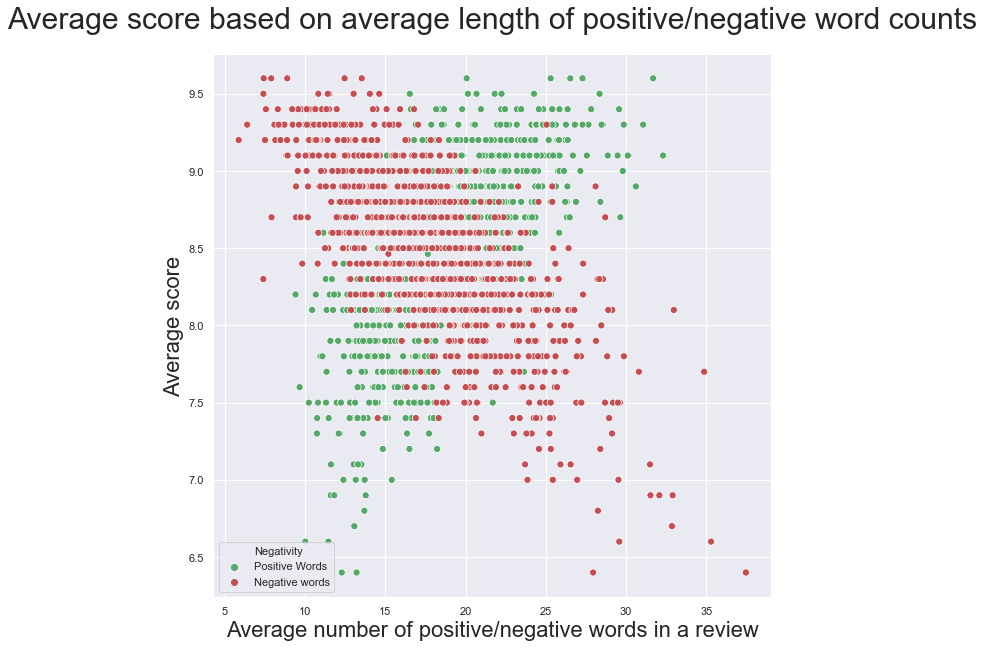

In [56]:
plt.figure(figsize=(10, 10))
sb.scatterplot(x=conc["wc"], y=conc["mean"], data=conc, hue="Negativity", palette=["g", "r"], s=50)

plt.title("Average score based on average length of positive/negative word counts", fontsize=30, pad=25)
plt.xlabel("Average number of positive/negative words in a review", fontsize=22)
plt.ylabel("Average score", fontsize=22)

plt.show()

#We can see the expected relationship of average number of positive/negative words and average score
#Hotels who are getting more negative words in their reviews are more likely to have bad rating and vice versa

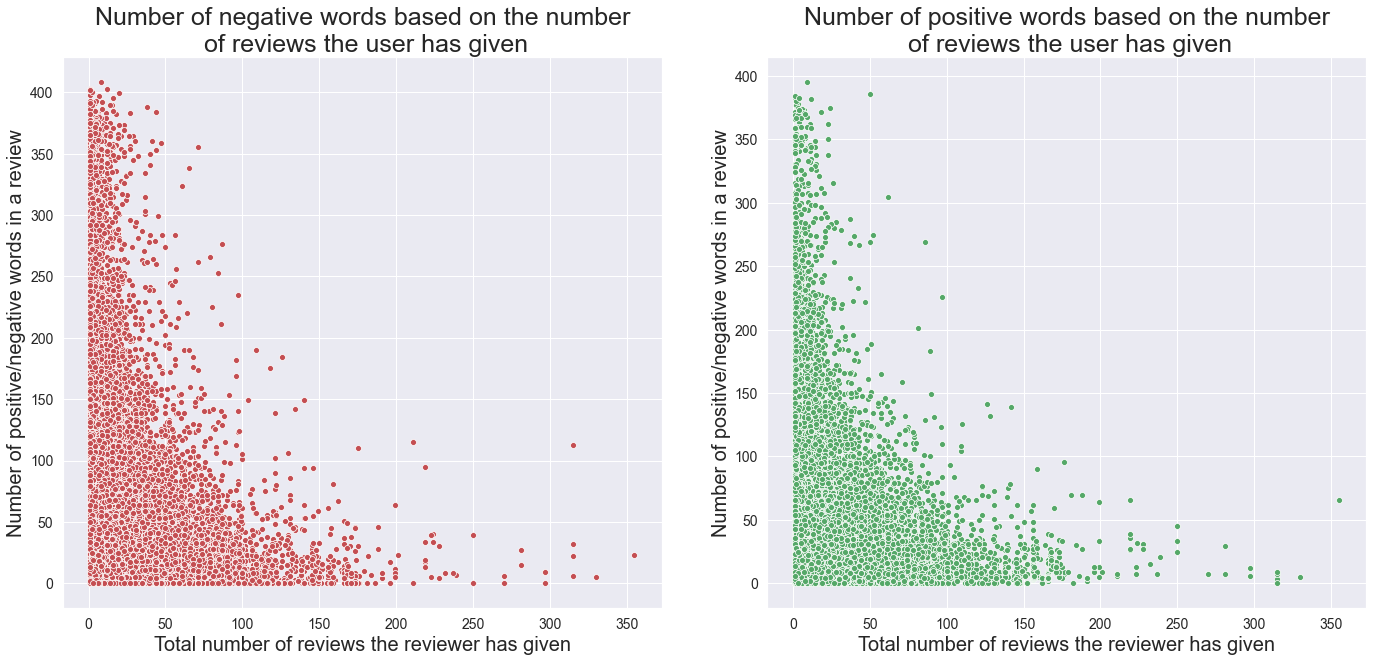

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

sb.scatterplot(x=df["Total_Number_of_Reviews_Reviewer_Has_Given"], y=df["Review_Total_Negative_Word_Counts"], color="r", ax=axs[0])
axs[0].set_title("Number of negative words based on the number\n of reviews the user has given", fontsize=25)

sb.scatterplot(x=df["Total_Number_of_Reviews_Reviewer_Has_Given"], y=df["Review_Total_Positive_Word_Counts"], color="g", ax=axs[1])
axs[1].set_title("Number of positive words based on the number\n of reviews the user has given", fontsize=25)

for ax in axs.flat:
    ax.set_xlabel("Total number of reviews the reviewer has given", fontsize=20)
    ax.set_ylabel("Number of positive/negative words in a review", fontsize=20)
    ax.tick_params(labelsize=14)
    
    #ax.label_outer()

fig.tight_layout(pad=3.0)

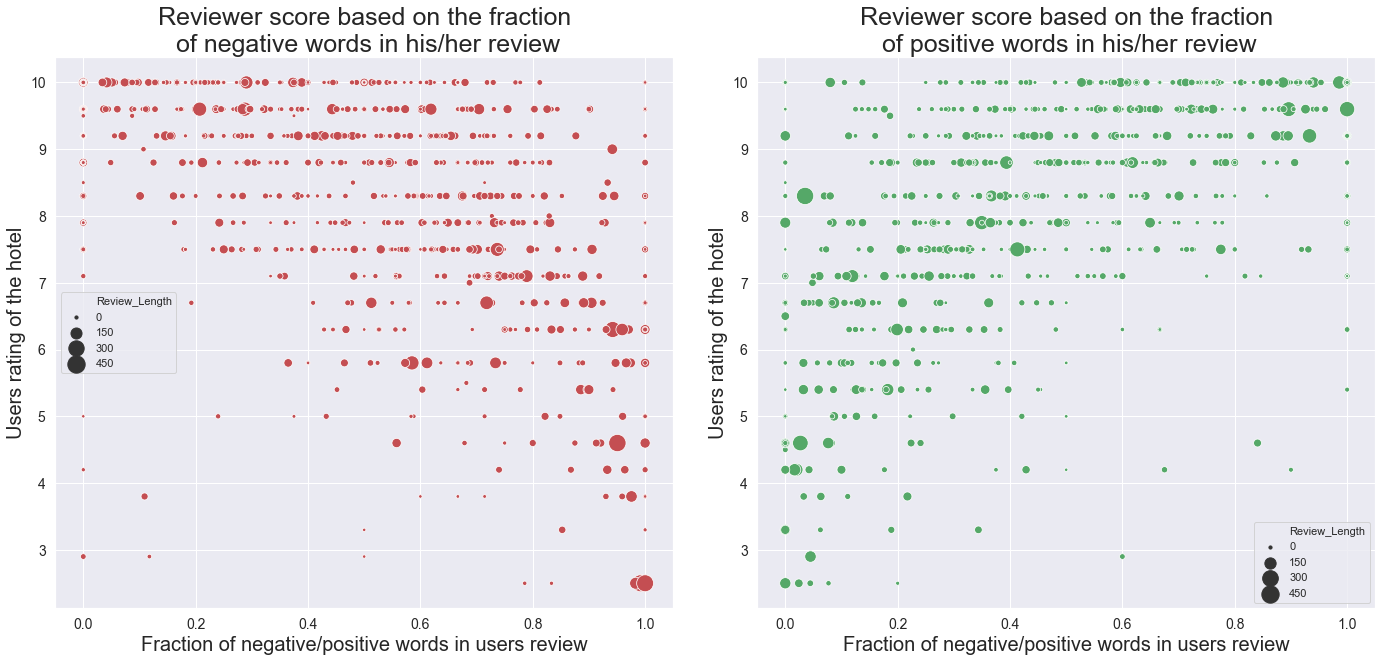

In [58]:
pos_samp = df[df["Review_Length"] != 0].sample(1000)
neg_samp = df[df["Review_Length"] != 0].sample(1000)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

sb.scatterplot(x=neg_samp["Review_Total_Negative_Word_Counts"]/neg_samp["Review_Length"], y=neg_samp["Reviewer_Score"], 
               color="r", ax=axs[0], size=neg_samp["Review_Length"], sizes=(10, 300))
axs[0].set_title("Reviewer score based on the fraction\n of negative words in his/her review", fontsize=25)

sb.scatterplot(x=pos_samp["Review_Total_Positive_Word_Counts"]/pos_samp["Review_Length"], y=pos_samp["Reviewer_Score"], 
               color="g", ax=axs[1], size=pos_samp["Review_Length"], sizes=(10, 300))
axs[1].set_title("Reviewer score based on the fraction\n of positive words in his/her review", fontsize=25)

for ax in axs.flat:
    ax.set_xlabel("Fraction of negative/positive words in users review", fontsize=20)
    ax.set_ylabel("Users rating of the hotel", fontsize=20)
    ax.tick_params(labelsize=14)
    
    #ax.label_outer()

fig.tight_layout(pad=3.0)

In [14]:
def count_upper_words(entry):
    uppers = [word for word in entry.split() if word.isupper()]
    return len(uppers)

In [15]:
df["Positive_Review_Caps_Words"] = df["Positive_Review"].apply(count_upper_words)
df["Negative_Review_Caps_Words"] = df["Negative_Review"].apply(count_upper_words)

In [16]:
def find_rare(data):
    return Counter(' '.join(data).split())

In [19]:
stops = stopwords.words("english")
word_counts = find_rare(df["Positive_Review"] + df["Negative_Review"])

def preprocess(entry):
    entry = " ".join(x.lower() for x in entry.split()).replace("[^\w\s]", "")
    
    entry = " ".join(x for x in entry.split() if x not in stops)
    
    entry = " ".join(x for x in entry.split() if word_counts[x] > 50)
    
    return entry

In [20]:
df["Positive_Review"] = df["Positive_Review"].apply(preprocess)
df["Negative_Review"] = df["Negative_Review"].apply(preprocess)

In [21]:
lemmatizer = WordNetLemmatizer()

def lemmatization(entry):
    return [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(entry)]

In [22]:
df["Positive_Review"] = df["Positive_Review"].apply(lemmatization)

In [23]:
df["Negative_Review"] = df["Negative_Review"].apply(lemmatization)

In [24]:
def find_pos_sent(entry):
    if "nothing" in entry:
        return -1
    elif "everything" in entry:
        return 1
    else:
        return TextBlob(" ".join(entry)).sentiment[0]

In [25]:
def find_neg_sent(entry):
    if "nothing" in entry:
        return 1
    elif "everything" in entry:
        return -1
    else:
        return TextBlob(" ".join(entry)).sentiment[0]

In [26]:
df["Positive_Review_Sentiment"] = df["Positive_Review"].apply(find_pos_sent)
df["Negative_Review_Sentiment"] = df["Negative_Review"].apply(find_neg_sent)

In [27]:
cv_pos = CountVectorizer(analyzer="word", lowercase=False, stop_words=None, max_features=10, ngram_range=(2, 4))

cv_pos_matrix = cv_pos.fit_transform([rev for rev in df["Positive_Review"].apply(lambda x: " ".join(x))])
pos_counts = cv_pos_matrix.sum(axis=0)
pos_words = cv_pos.vocabulary_

In [28]:
cv_neg = CountVectorizer(analyzer="word", lowercase=False, stop_words=None, max_features=10, ngram_range=(2, 4))

cv_neg_matrix = cv_neg.fit_transform([rev for rev in df["Negative_Review"].apply(lambda x: " ".join(x))])
neg_counts = cv_neg_matrix.sum(axis=0)
neg_words = cv_neg.vocabulary_

In [72]:
#The most impactful pairs of words in positive reviews

pos_words

{'great location': 5,
 'good location': 4,
 'friendly staff': 3,
 'staff friendly': 8,
 'friendly helpful': 2,
 'helpful staff': 6,
 'staff helpful': 9,
 'room clean': 7,
 'comfortable bed': 0,
 'excellent location': 1}

In [73]:
#The most impactful pairs of words in negative reviews

neg_words

{'booking com': 2,
 'small room': 7,
 'tea coffee': 9,
 'room service': 5,
 'room little': 4,
 'star hotel': 8,
 'room small': 6,
 'air con': 0,
 'air conditioning': 1,
 'room bit': 3}

In [74]:
#Creating columns for the observed keywords, first positive ones, then negative ones

In [29]:
df["PR_Good_Loc"] = df["Positive_Review"].apply(lambda x: 1 if "location" in x and ("excellent" in x or "good" in x or "perfect" in x or "great" in x) else 0)
df["PR_Friendly_Staff"] = df["Positive_Review"].apply(lambda x: 1 if ("friendly" in x or "helpful" in x) and "staff" in x else 0)
df["PR_Clean_Room"] = df["Positive_Review"].apply(lambda x: 1 if "clean" in x and "room" in x else 0)
df["PR_Comfortable_Bed"] = df["Positive_Review"].apply(lambda x: 1 if ("comfortable" in x or"comfy" in x) and "bed" in x else 0)
df["PR_Everything"] = df["Positive_Review"].apply(lambda x: 1 if "everything" in x else 0)
df["NR_Nothing"] = df["Negative_Review"].apply(lambda x: 1 if "nothing" in x else 0)

In [30]:
df["NR_Booking"] = df["Negative_Review"].apply(lambda x: 1 if "booking" in x and "com" in x else 0)
df["NR_Small_Room"] = df["Negative_Review"].apply(lambda x: 1 if "room" in x and ("small" in x or "little" in x) else 0)
df["NR_Room_Service"] = df["Negative_Review"].apply(lambda x: 1 if "room" in x and "service" in x else 0)
df["NR_Air_Conditioning"] = df["Negative_Review"].apply(lambda x: 1 if "air" in x or "conditioning" in x else 0)
df["NR_Everything"] = df["Negative_Review"].apply(lambda x: 1 if "everything" in x else 0)
df["PR_Nothing"] = df["Positive_Review"].apply(lambda x: 1 if "nothing" in x else 0)

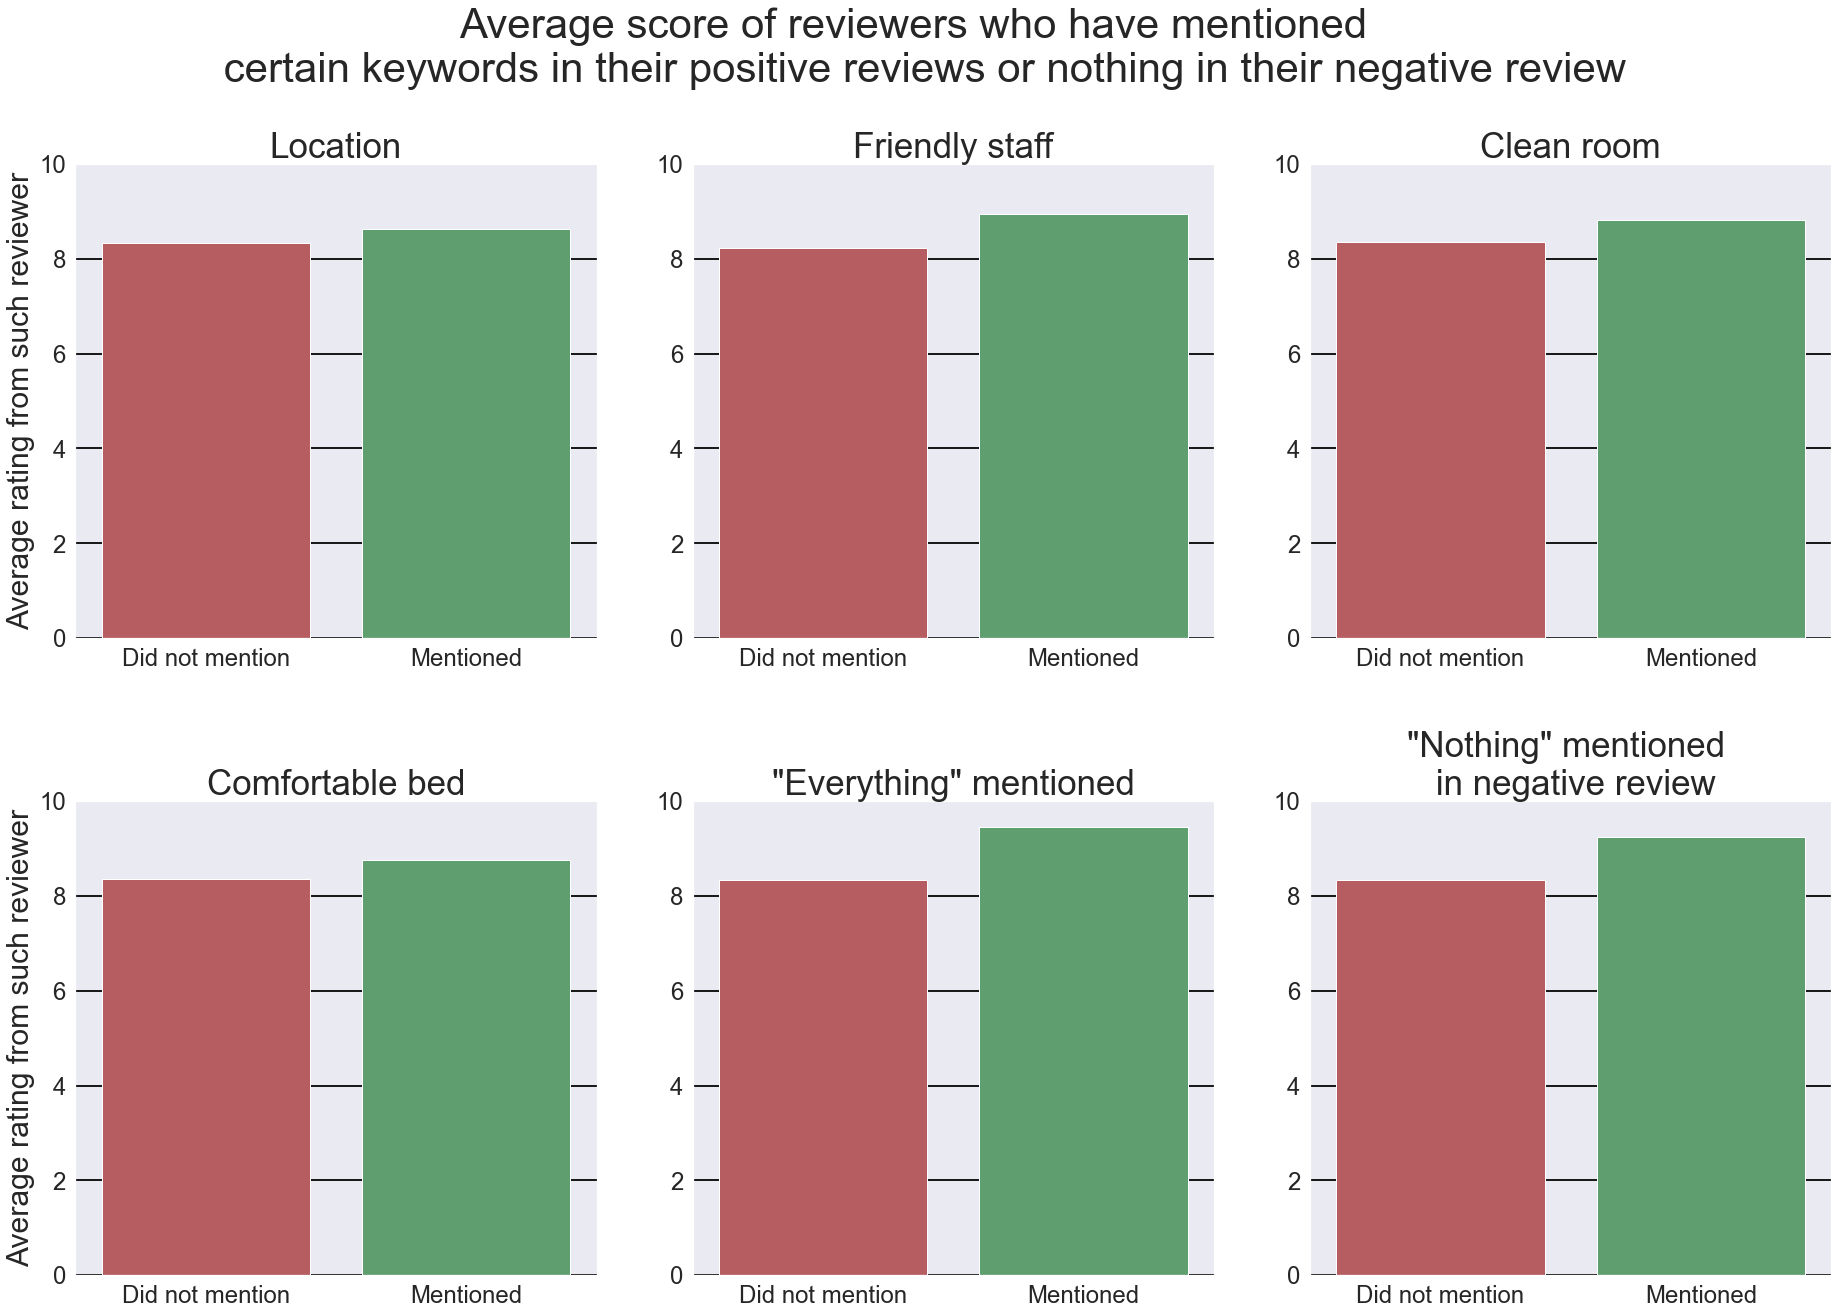

In [77]:
fig, axs = plt.subplots(2, 3, figsize=(27, 18))
plt.suptitle("Average score of reviewers who have mentioned \n certain keywords in their positive reviews or nothing in their negative review", 
             fontsize=42, y=1.05)

positive = {"Location": "PR_Good_Loc", "Friendly staff": "PR_Friendly_Staff",
           "Clean room": "PR_Clean_Room", "Comfortable bed": "PR_Comfortable_Bed",
           "\"Everything\" mentioned": "PR_Everything", "\"Nothing\" mentioned \n in negative review": "NR_Nothing"}

i = 0
j = 0
for pos in positive:
    dat = df.groupby(positive[pos]).Reviewer_Score.agg(["mean"]).reset_index()
    sb.barplot(x=positive[pos], y="mean", data=dat, ax=axs[i, j], palette=["r", "g"])
    
    axs[i, j].set_title(f"{pos}", size=35)
    axs[i, j].set_xlabel("")
    axs[i, j].set_ylabel("Average rating from such reviewer", fontsize=30)
    axs[i, j].tick_params(labelsize=24)
    axs[i, j].grid(which="both", axis="y", linewidth=2, color="k")
    
    if j:
        axs[i, j].set_ylabel("")
    
    j += 1
    if j == 3:
        j = 0
        i += 1

plt.setp(axs, xticks=(0, 1), xticklabels=["Did not mention", "Mentioned"], yticks=range(0, 11, 2))

fig.tight_layout(pad=5.0)
plt.show()

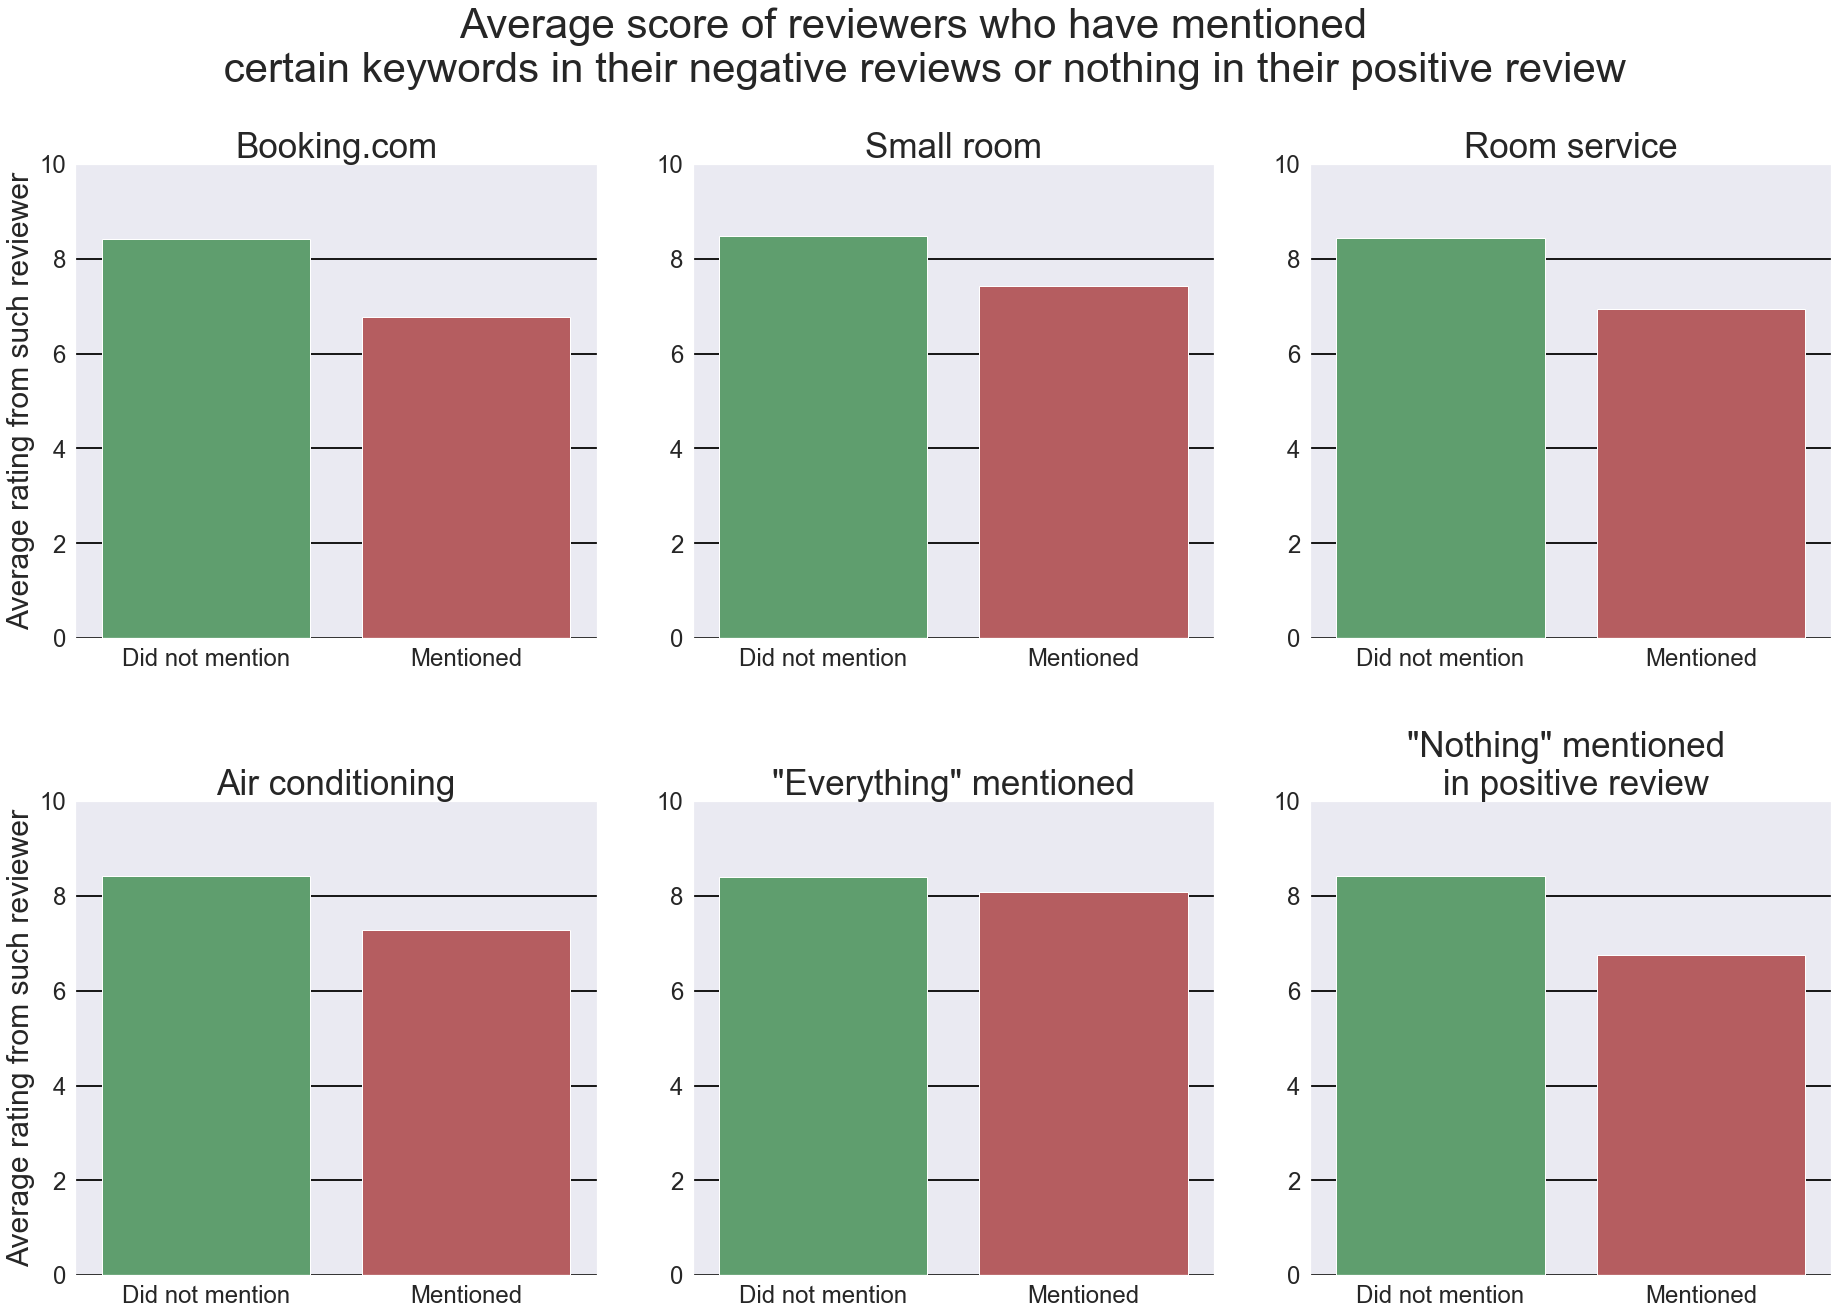

In [78]:
fig, axs = plt.subplots(2, 3, figsize=(27, 18))
plt.suptitle("Average score of reviewers who have mentioned \n certain keywords in their negative reviews or nothing in their positive review", 
             fontsize=42, y=1.05)

negative = {"Booking.com": "NR_Booking", "Small room": "NR_Small_Room",
           "Room service": "NR_Room_Service", "Air conditioning": "NR_Air_Conditioning",
           "\"Everything\" mentioned": "NR_Everything", "\"Nothing\" mentioned \n in positive review": "PR_Nothing"}

i = 0
j = 0
for neg in negative:
    dat = df.groupby(negative[neg]).Reviewer_Score.agg(["mean"]).reset_index()
    sb.barplot(x=negative[neg], y="mean", data=dat, ax=axs[i, j], palette=["g", "r"])
    
    axs[i, j].set_title(f"{neg}", size=35)
    axs[i, j].set_xlabel("")
    axs[i, j].set_ylabel("Average rating from such reviewer", fontsize=30)
    axs[i, j].tick_params(labelsize=24)
    axs[i, j].grid(which="both", axis="y", linewidth=2, color="k")
    
    if j:
        axs[i, j].set_ylabel("")
    
    j += 1
    if j == 3:
        j = 0
        i += 1

plt.setp(axs, xticks=(0, 1), xticklabels=["Did not mention", "Mentioned"], yticks=range(0, 11, 2))

fig.tight_layout(pad=5.0)
plt.show()

<h2>Correlation</h2>

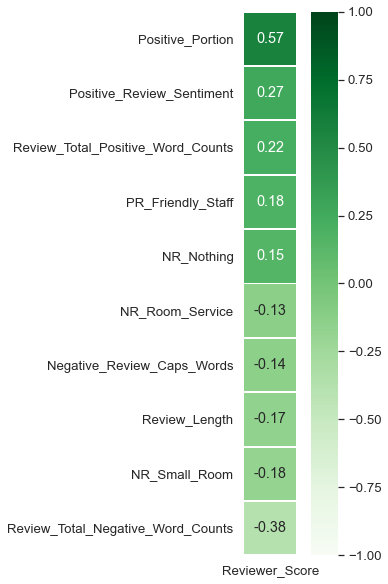

In [32]:
temp = df.copy()
temp["Positive_Portion"] = (temp["Review_Total_Positive_Word_Counts"]+1)/(temp["Review_Total_Positive_Word_Counts"] + temp["Review_Total_Negative_Word_Counts"] + 1)
temp["days_since_review"] = df_orig["days_since_review"].apply(lambda x: int(x.split()[0]))

temp = pd.concat([pd.get_dummies(temp["Hotel_Country"]), temp.drop(columns=["Hotel_Country"])], axis=1)
temp = pd.concat([pd.get_dummies(temp["Travel_Purpose"]), temp.drop(columns=["Travel_Purpose"])], axis=1)
temp = pd.concat([pd.get_dummies(temp["Traveled_as"]), temp.drop(columns=["Traveled_as"])], axis=1)

df_corr = temp.corr().round(2)
score_corr = pd.DataFrame(df_corr[abs(df_corr["Reviewer_Score"]) > 0.05].drop(["Reviewer_Score", "Average_Score"],
                                                                  axis=0)["Reviewer_Score"].sort_values(ascending=False))

plt.figure(figsize=(5, 10))
sb.set(font_scale=1.2)

sb.heatmap(pd.concat([score_corr.head(), score_corr.tail()]), vmin=-1, vmax=1, 
           square=True, cmap="Greens", annot=True, linewidths=1)

plt.show()

<h2>Creating, training and evaluating models for regression tasks as well as inspecting their feature importance</h2>

In [33]:
df_model = temp.copy()
df_model = df_model.loc[:, [_ for _ in score_corr.index.tolist() + ["Reviewer_Score"]]]
df_model.drop(columns=["Total_Number_of_Reviews", "Review_Total_Negative_Word_Counts", 
                       "Leisure trip", "Review_Length", "Review_Total_Positive_Word_Counts"], inplace=True)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Positive_Portion            515738 non-null  float64
 1   Positive_Review_Sentiment   515738 non-null  float64
 2   PR_Friendly_Staff           515738 non-null  int64  
 3   NR_Nothing                  515738 non-null  int64  
 4   PR_Everything               515738 non-null  int64  
 5   PR_Good_Loc                 515738 non-null  int64  
 6   PR_Clean_Room               515738 non-null  int64  
 7   Negative_Review_Sentiment   515738 non-null  float64
 8   PR_Comfortable_Bed          515738 non-null  int64  
 9   Couple                      515738 non-null  uint8  
 10  Positive_Review_Caps_Words  515738 non-null  int64  
 11  Solo traveler               515738 non-null  uint8  
 12  NR_Booking                  515738 non-null  int64  
 13  NR_Air_Conditi

In [34]:
X = df_model.loc[:, ["Positive_Portion", "Positive_Review_Sentiment", "Negative_Review_Sentiment",
                    "PR_Friendly_Staff", "PR_Nothing", "NR_Room_Service", "NR_Nothing", "NR_Air_Conditioning",
                    "NR_Small_Room", "PR_Comfortable_Bed", "NR_Booking", "PR_Good_Loc", "Business trip",
                    "PR_Clean_Room"]]
y = df_model.loc[:, "Reviewer_Score"]

In [35]:
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=1)

In [138]:
lin_reg = LinearRegression(normalize=True, n_jobs=-1)
lin_reg.fit(train_X, train_y)
lin_reg_preds = lin_reg.predict(val_X)
print("Linear Regression Score:", lin_reg.score(val_X, val_y))
print("Linear Regression MAE:", mean_absolute_error(lin_reg_preds, val_y))
print("Linear Regression RMSE:", (mean_squared_error(lin_reg_preds, val_y))*(1/2))

Linear Regression Score: 0.3943237922597732
Linear Regression MAE: 0.9647695259945873
Linear Regression RMSE: 0.8137410948884014


In [85]:
perm_lin_reg = PermutationImportance(lin_reg, random_state=0).fit(val_X, val_y)
eli5.show_weights(perm_lin_reg, feature_names=val_X.columns.tolist(), top=30)

Weight,Feature
0.5553 ± 0.0036,Positive_Portion
0.0607 ± 0.0011,Positive_Review_Sentiment
0.0586 ± 0.0010,Negative_Review_Sentiment
0.0128 ± 0.0007,PR_Friendly_Staff
0.0074 ± 0.0007,Business trip
0.0061 ± 0.0003,NR_Nothing
0.0059 ± 0.0006,NR_Small_Room
0.0043 ± 0.0002,NR_Room_Service
0.0025 ± 0.0003,PR_Comfortable_Bed
0.0025 ± 0.0002,PR_Good_Loc


In [86]:
coefs = {}

for ind, col in enumerate(X.columns):
    coefs[col] = lin_reg.coef_[ind]
    
coefs

{'Positive_Portion': 2.689248507590456,
 'Positive_Review_Sentiment': 0.8530150560924653,
 'Negative_Review_Sentiment': 0.695322381198258,
 'PR_Friendly_Staff': 0.3031242947524301,
 'PR_Nothing': -0.3215058978821075,
 'NR_Room_Service': -0.5114369316889563,
 'NR_Nothing': -0.35121551160233316,
 'NR_Air_Conditioning': -0.36226603688793996,
 'NR_Small_Room': -0.3207231749047921,
 'PR_Comfortable_Bed': 0.19617434396160757,
 'NR_Booking': -0.4403053072642771,
 'PR_Good_Loc': -0.134194638655311,
 'Business trip': -0.2621463260300067,
 'PR_Clean_Room': 0.1105815448189427}

In [87]:
dtr = DecisionTreeRegressor(random_state=1)
dtr.fit(train_X, train_y)
dtr_preds = dtr.predict(val_X)
print("Decision Tree Regressor Score:", dtr.score(val_X, val_y))
print("Decision Tree Regressor MAE:", mean_absolute_error(dtr_preds, val_y))
print("Decision Tree Regressor RMSE:", (mean_squared_error(dtr_preds, val_y))*(1/2))

Decision Tree Regressor Score: 0.07867907318871226
Decision Tree Regressor MAE: 1.1389822799291238
Decision Tree Regressor RMSE: 1.2378176493413886


In [88]:
perm_dtr = PermutationImportance(dtr, random_state=0).fit(val_X, val_y)
eli5.show_weights(perm_dtr, feature_names=val_X.columns.tolist(), top=30)

Weight,Feature
0.7620 ± 0.0151,Positive_Portion
0.2803 ± 0.0098,Positive_Review_Sentiment
0.1211 ± 0.0045,Negative_Review_Sentiment
0.0486 ± 0.0006,PR_Nothing
0.0285 ± 0.0034,PR_Friendly_Staff
0.0204 ± 0.0050,PR_Good_Loc
0.0157 ± 0.0023,NR_Small_Room
0.0135 ± 0.0013,PR_Clean_Room
0.0085 ± 0.0026,Business trip
0.0053 ± 0.0007,NR_Nothing


In [89]:
rfr = RandomForestRegressor(random_state=1, n_jobs=-1)
rfr.fit(train_X, train_y)
rfr_preds = rfr.predict(val_X)
print("Random Forest Regressor Score:", rfr.score(val_X, val_y))
print("Random Forest Regressor MAE:", mean_absolute_error(rfr_preds, val_y))
print("Random Forest Regressor RMSE:", (mean_squared_error(rfr_preds, val_y))*(1/2))

Random Forest Regressor Score: 0.3897948355991774
Random Forest Regressor MAE: 0.954331941613645
Random Forest Regressor RMSE: 0.819825861145682


In [90]:
perm_rfr = PermutationImportance(rfr, random_state=0).fit(val_X, val_y)
eli5.show_weights(perm_rfr, feature_names=val_X.columns.tolist(), top=30)

Weight,Feature
0.6945 ± 0.0058,Positive_Portion
0.1987 ± 0.0048,Positive_Review_Sentiment
0.0641 ± 0.0033,Negative_Review_Sentiment
0.0416 ± 0.0005,PR_Nothing
0.0154 ± 0.0011,PR_Friendly_Staff
0.0132 ± 0.0019,PR_Good_Loc
0.0082 ± 0.0012,Business trip
0.0070 ± 0.0007,NR_Small_Room
0.0047 ± 0.0006,PR_Clean_Room
0.0026 ± 0.0007,NR_Room_Service


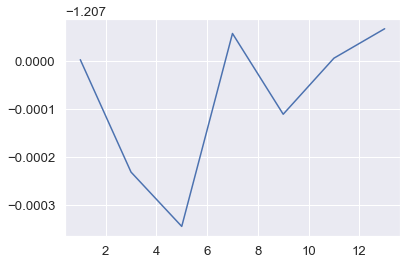

In [103]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.model_selection import cross_val_score

num_features = []
accs = []

for i in range(1, len(X.columns)+1, 2):
    num_features.append(i)
    
    hgbr = HistGradientBoostingRegressor()
    
    sfs1 = sfs(hgbr, k_features=i, forward=True, floating=False, scoring="neg_root_mean_squared_error", verbose=0, cv=3)
    sfs1 = sfs1.fit(train_X, train_y)
    
    new_X = df_model[[X.columns[val] for val in list(sfs1.k_feature_idx_)]]
    new_train_X, new_val_X, train_y, val_y = train_test_split(new_X, y, test_size=0.2, random_state=1)
    
    hgbr = HistGradientBoostingRegressor()
    hgbr.fit(new_train_X, train_y)
    hgbr_preds = hgbr.predict(new_val_X)
    
    accs.append(np.mean(cross_val_score(hgbr, X, y, scoring="neg_root_mean_squared_error")))

plt.plot(num_features, accs)

In [39]:
est = HistGradientBoostingRegressor()
est.fit(train_X, train_y)
est_preds = est.predict(val_X)
print("Histogram Gradient Booster Score:", est.score(val_X, val_y))
print("Histogram Gradient Booster MAE:", mean_absolute_error(est_preds, val_y))
print("Histogram Gradient Booster RMSE:", (mean_squared_error(est_preds, val_y))*(1/2))

Histogram Gradient Booster Score: 0.45791464826131656
Histogram Gradient Booster MAE: 0.9092067924142656
Histogram Gradient Booster RMSE: 0.7283051934508127


In [97]:
perm_est = PermutationImportance(est, random_state=0).fit(val_X, val_y)
eli5.show_weights(perm_est, feature_names=val_X.columns.tolist(), top=30)

Weight,Feature
0.6448 ± 0.0027,Positive_Portion
0.1391 ± 0.0026,Positive_Review_Sentiment
0.0491 ± 0.0015,Negative_Review_Sentiment
0.0138 ± 0.0006,PR_Friendly_Staff
0.0117 ± 0.0010,PR_Good_Loc
0.0077 ± 0.0002,PR_Nothing
0.0071 ± 0.0006,Business trip
0.0068 ± 0.0005,NR_Small_Room
0.0028 ± 0.0007,PR_Comfortable_Bed
0.0019 ± 0.0003,NR_Nothing


In [82]:
import statsmodels.api as sm

X_sm = X = sm.add_constant(X)
model = sm.OLS(y, X_sm)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Reviewer_Score   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                 2.400e+04
Date:                Tue, 14 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:19:40   Log-Likelihood:            -8.5687e+05
No. Observations:              515738   AIC:                         1.714e+06
Df Residuals:                  515723   BIC:                         1.714e+06
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         6.5384      0.005   1385.023      0.000       6.529       6.548
Positive_Portion              2.6874      0.006    422.310      0.000       2.675       2.700
Positive_Review_Sentiment     0.8586      0.006    132.763      0.000       0.846       0.871
Negative_Review_Sentiment     0.6963      0.007    102.608      0.000       0.683       0.710
PR_Friendly_Staff             0.3062      0.004     70.147      0.000       0.298       0.315
PR_Nothing                   -0.2959      0.018    -16.193      0.000      -0.332      -0.260
NR_Room_Service              -0.5152      0.013    -40.957      0.000      -0.540      -0.491
NR_Nothing                   -0.3499      0.010    -34.014      0.000      -0.370      -0.330
NR_Air_Conditioning          -0.3558      0.012    -30.035      0.000      -0.379      -0.333
NR_Small_Room                -0.3191      0.007    -48.145      0.000      -0.332      -0.306
PR_Comfortable_Bed            0.1966      0.006     31.376      0.000       0.184       0.209
NR_Booking                   -0.4539      0.021    -21.984      0.000      -0.494      -0.413
PR_Good_Loc                  -0.1366      0.004    -30.696      0.000      -0.145      -0.128
Business trip                -0.2660      0.005    -55.431      0.000      -0.275      -0.257
PR_Clean_Room                 0.1096      0.007     16.472      0.000       0.097       0.123
==============================================================================
Omnibus:                    49106.139   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            80150.147
Skew:                          -0.699   Prob(JB):                         0.00
Kurtosis:                       4.333   Cond. No.                         15.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<h2>Possible next steps:</h2>

    • Polish the algorithms using feature selection
    • Transform the dependent variable (reviewer score) into an ordered categorical one -> try to implement classification  algorithms